## Import required packages

In [1]:
import sys
import os
from netCDF4 import Dataset
import numpy as np
import datetime
from ipywidgets import*
import ipywidgets as widgets
import warnings
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid, addcyclic
import matplotlib.mlab as mlab
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
from pylab import *
from matplotlib.patches import Polygon
import time
import pandas as pd
from scipy.special import erf
import matplotlib.colors as colors
from matplotlib import ticker, cm
import igrf12

## Import daedalusmase packages


In [2]:
#Define daedalusmase_derived_products package location
fpath = os.path.abspath("../")
print(fpath)
#add src path to python path
sys.path.append(fpath)

#Define data path
datapath='../../Sample_Data/tiegcm_data/'

#import mod_collision_freqs_cross_sections module
import daedalusmase_derived_products.mod_collision_freqs_cross_sections.sub_collision_frequencies as cols

#import mod_collision_freqs_cross_sections module
import daedalusmase_derived_products.mod_collision_freqs_cross_sections.sub_cross_sections as cross_sec

#import mod_conductivities module
import daedalusmase_derived_products.mod_conductivities as cond

#import mod_currents_magnetic_forcing module
import daedalusmase_derived_products.mod_currents_magnetic_forcing as currents

#import mod_tiegcm_utils module
import daedalusmase_derived_products.mod_tiegcm_utils as tiegcm

#import mod_heating_sources module.sub_heating_rates
import daedalusmase_derived_products.mod_heating_sources.sub_heating_rates as heatings

#import mod_heating_sources module.sub_cooling_rates
import daedalusmase_derived_products.mod_heating_sources.sub_cooling_rates as coolings

#import mod_heating_sources module.sub_heat_transfer_rates
import daedalusmase_derived_products.mod_heating_sources.sub_heat_transfer_rates as transfers

#import mod_heating_sources module.sub_heating_rates
import daedalusmase_derived_products.mod_heating_sources.sub_frictional_heating_rates as frictionals


from daedalusmase_derived_products.mod_tiegcm_utils import allocations as alloc

#import mod_heating_sources module.sub_plot_utils
import daedalusmase_derived_products.mod_plot_utils as plots



/home/tourgaidis/Επιφάνεια εργασίας/GitHub/DaedalusMASE/daedalusmase_derived_products


## Define begining time of tiegcm files

In [3]:
time_tiegcm = datetime.datetime(2015, 3, 15, 0, 0, 0)  # first time step of the TIEGCM run

## 1D Run

In [4]:
#Calculation of products for map plotting
def run(tiegcm_file,lat_value,lon_value,timer_value):
    start_time = time.time()

    for timer in range(timer_value,timer_value+1):

        #keep time for plot titles
        time_plot=tiegcm.read_tiegcm(tiegcm_file,'time',timer, np.nan, np.nan, np.nan)
        alloc.maptime[timer]=time_plot

        for lev in range(0, 57):
            
            for lat in range(lat_value, lat_value+1):

                for lon in range(lon_value, lon_value+1):
                    
                    ########################################################################
#                   Coordinates
                    ########################################################################
    
                    XNMBAR_f=tiegcm.read_tiegcm(tiegcm_file,'XNMBAR',timer, lev, lat, lon)
                    
                    # GEO coordinates of desired point
                    alt_p = tiegcm.read_tiegcm(tiegcm_file,'ZGMID',timer, lev, lat, lon)
                    lat_p = tiegcm.read_tiegcm(tiegcm_file,'lat',timer, lev, lat, lon)
                    lon_p = tiegcm.read_tiegcm(tiegcm_file,'lon',timer, lev, lat, lon)
                    timeg = tiegcm.read_tiegcm(tiegcm_file,'time',timer, lev, lat, lon)
                    
                    alloc.zg_1D.append(alt_p)
                    alloc.lat_1D.append(lat_p)
                    alloc.lon_1D.append(lon_p)
                    alloc.maplat[lat]=lat_p #output 
                    alloc.maplon[lon]=lon_p #output 
 
                    #time
                    
                    #calculate time of the time step
                    time_p = time_tiegcm + datetime.timedelta(minutes=int(timeg))   
                    

                    ########################################################################
#                   Temperatures and densities
                    ########################################################################
                    
                    denf = tiegcm.read_tiegcm(tiegcm_file,'DEN',timer, lev, lat, lon)
                    
                    
                    #Temperatures
                    Tn = tiegcm.read_tiegcm(tiegcm_file,'TN',timer, lev, lat, lon)    #Kelvin
                    Te = tiegcm.read_tiegcm(tiegcm_file,'TE',timer, lev, lat, lon)
                    Ti = tiegcm.read_tiegcm(tiegcm_file,'TI',timer, lev, lat, lon)
                    
                    alloc.Tn_1D.append(Tn)
                    alloc.Ti_1D.append(Ti)
                    alloc.Te_1D.append(Te)
                    
                    # electron density
                    Ne = tiegcm.read_tiegcm(tiegcm_file,'ELECDEN',timer, lev, lat, lon) * (10 ** 6)  # m^-3
                    Necm = tiegcm.read_tiegcm(tiegcm_file,'ELECDEN',timer, lev, lat, lon) # (cm^-3)
                    
                    alloc.Ne_1D.append(Necm)
                    #ion Densities
                    NOp = tiegcm.read_tiegcm(tiegcm_file,'OP',timer, lev, lat, lon)  #cm^-3
                    NO2p = tiegcm.read_tiegcm(tiegcm_file,'O2P',timer, lev, lat, lon)  #cm^-3
                    Nplus = tiegcm.read_tiegcm(tiegcm_file,'NPLUS',timer, lev, lat, lon)
                    NNOp = tiegcm.read_tiegcm(tiegcm_file,'NOP_LAM',timer, lev, lat, lon)
                    
                    alloc.NOp_1D.append(NOp)
                    alloc.NO2p_1D.append(NO2p)
                    alloc.Np_1D.append(Nplus)
                    alloc.NNOp_1D.append(NNOp)
                    
                    #neutral Densities (cm^-3)
                    NO = tiegcm.read_tiegcm(tiegcm_file,'O_CM3',timer, lev, lat, lon) #cm^-3
                    NO2 = tiegcm.read_tiegcm(tiegcm_file,'O2_CM3',timer, lev, lat, lon) #cm^-3                 
                    NN2 = tiegcm.read_tiegcm(tiegcm_file,'N2_CM3',timer, lev, lat, lon)#cm^-3
                    
                    alloc.NO_1D.append(NO)
                    alloc.NO2_1D.append(NO2)
                    alloc.NN2_1D.append(NN2)
                    
                    #Neutral densities in mmr
                    HE_mmr = tiegcm.read_tiegcm(tiegcm_file,'HE',timer, lev, lat, lon)
                    
                    #convert from mmr to cm^-3
                    NHe=tiegcm.convert_mmr(HE_mmr,XNMBAR_f,tiegcm.const.Ar_helium)
                    alloc.NHe_1D.append(NHe)
                    ########################################################################
#                   Magnetic field
                    ########################################################################
                    
#                     #IGRF magnetic field
#                     B_enu,b_unit_enu=tiegcm.igrf_B(time_p, lat_p, lon_p, alt_p)
                    
                    Be=tiegcm.read_tiegcm(tiegcm_file,'BX',timer, lev, lat, lon)
                    Bn=tiegcm.read_tiegcm(tiegcm_file,'BY',timer, lev, lat, lon)
                    Bu=tiegcm.read_tiegcm(tiegcm_file,'BZ',timer, lev, lat, lon)
                    B_enu=[Be,Bn,Bu]
                    Bmag=np.sqrt(Be*Be+Bn*Bn+Bu*Bu)
                    b_unit=[Be/Bmag,Bn/Bmag,Bu/Bmag]
                    
                    alloc.Be_1D.append(Be)
                    alloc.Bn_1D.append(Bn)
                    alloc.Bu_1D.append(Bu)
                    alloc.Bmag_1D.append(Bmag)
                    
                    ########################################################################
#                   Neutral Wind and Electric Field
                    ########################################################################
    
                    ########################################################################
                    #Nautral velocity

                    Une = tiegcm.read_tiegcm(tiegcm_file,'UN',timer, lev, lat, lon)
                    Unn = tiegcm.read_tiegcm(tiegcm_file,'VN',timer, lev, lat, lon)
                    Unu = tiegcm.read_tiegcm(tiegcm_file,'WN_lev',timer, lev, lat, lon)
                    Un = [Une, Unn, Unu] # neutral wind in ENU in m/s
                    
                    # ExB velocity in ENU in m/s
                    

                    
                    Uie = tiegcm.read_tiegcm(tiegcm_file,'Ui_lev',timer, lev, lat, lon)
                    Uin = tiegcm.read_tiegcm(tiegcm_file,'Vi_lev',timer, lev, lat, lon)
                    Uiu = tiegcm.read_tiegcm(tiegcm_file,'Wi_lev',timer, lev, lat, lon)
                    Ui = [Uie, Uin, Uiu]

                    alloc.Uie_1D.append(Uie)
                    alloc.Uin_1D.append(Uin)
                    alloc.Uiu_1D.append(Uiu)
                 
#                     #calculate electric fields from tiegcm.electric_field routine
#                     Evi,Estar=tiegcm.electric_field(Ui,Un,B_enu)
                    
                    Eetiegcm=tiegcm.read_tiegcm(tiegcm_file,'EEX',timer, lev, lat, lon)
                    Entiegcm=tiegcm.read_tiegcm(tiegcm_file,'EEY',timer, lev, lat, lon)
                    Eutiegcm=tiegcm.read_tiegcm(tiegcm_file,'EEZ',timer, lev, lat, lon) 
                    Evi=[Eetiegcm,Entiegcm,Eutiegcm]
                    
                    alloc.Ee_1D.append(Eetiegcm)
                    alloc.En_1D.append(Entiegcm)
                    alloc.Eu_1D.append(Eutiegcm)
                    
                    Un_perp=np.cross(Un,b_unit)
                    Une_perp=Un_perp[0]
                    Unn_perp=Un_perp[1]
                    Unu_perp=Un_perp[2]
                    Unvertmag=np.sqrt(Un_perp[0] * Un_perp[0] + Un_perp[1] * Un_perp[1] + Un_perp[2] * Un_perp[2]) 
                    alloc.Une_1D.append(Une_perp)
                    alloc.Unn_1D.append(Unn_perp)
                    alloc.Unu_1D.append(Unu_perp)                    
                    #Perpendicular electric field in neutral atmosphere reference frame                                        
                    Estar=Evi+np.cross(Un_perp,B_enu)

                    ##########################################################################
#                     Collision Frequencies
                    ##########################################################################
                
                    omega_e, omega_op, omega_o2p, omega_nop, omega_np=tiegcm.gyro_freqs(B_enu)
                    vin,vop_o,vop_o2,vop_n2,vop_he,vo2p_o,vo2p_o2,vo2p_n2,vo2p_he,vnop_o,vnop_o2,vnop_n2,vnop_he,vnp_o,vnp_o2,vnp_n2,vnp_he,vOp,vO2p,vNOp,vNp=cols.i_n_collision_freqs(B_enu,Ti,Tn,NO2,NO,NN2,NHe)
                    
                    ve_i, ve_op, ve_o2p, ve_nop, ve_np=cols.i_e_collision_freqs(NOp,NO2p,NNOp,Nplus,Te)
                    ven, ve_n2, ve_o, ve_o2, ve_he, rnu_ne=cols.e_n_collision_freqs(B_enu,NN2,NO2,NO,NHe,Te)
                    vop_op,vop_o2p,vop_nop,vop_np,vo2p_op,vo2p_o2p,vo2p_nop,vo2p_np,vnop_op,vnop_o2p,vnop_nop,vnop_np,vnp_op,vnp_o2p,vnp_nop,vnp_np=cols.i_i_collision_freqs(NOp,NO2p,NNOp,Nplus,Ti)
                    
                    alloc.omega_e_1D.append(omega_e)
                    alloc.omega_op_1D.append(omega_op)
                    alloc.omega_o2p_1D.append(omega_o2p)
                    alloc.omega_nop_1D.append(omega_nop)
                    alloc.omega_np_1D.append(omega_np)
                    
                    alloc.vin_1D.append(vin)
                    alloc.vop_o_1D.append(vop_o)
                    alloc.vop_o2_1D.append(vop_o2)
                    alloc.vop_n2_1D.append(vop_n2)
                    alloc.vop_he_1D.append(vop_he)
                    alloc.vo2p_o_1D.append(vo2p_o)
                    alloc.vo2p_o2_1D.append(vo2p_o2)
                    alloc.vo2p_n2_1D.append(vo2p_n2)
                    alloc.vo2p_he_1D.append(vo2p_he)
                    alloc.vnp_o_1D.append(vnp_o)
                    alloc.vnp_o2_1D.append(vnp_o2)
                    alloc.vnp_n2_1D.append(vnp_n2)
                    alloc.vnp_he_1D.append(vnp_he)
                    alloc.vnop_o_1D.append(vnop_o)
                    alloc.vnop_o2_1D.append(vnop_o2)
                    alloc.vnop_n2_1D.append(vnop_n2)
                    alloc.vnop_he_1D.append(vnop_he)
                    

                    alloc.ve_i_1D.append(ve_i)
                    alloc.ve_op_1D.append(ve_op)
                    alloc.ve_o2p_1D.append(ve_o2p)
                    alloc.ve_nop_1D.append(ve_nop)
                    alloc.ve_np_1D.append(ve_np)
                    alloc.ven_1D.append(ven)
                    alloc.ve_n2_1D.append(ve_n2)
                    alloc.ve_o_1D.append(ve_o)
                    alloc.ve_o2_1D.append(ve_o2)
                    alloc.ve_he_1D.append(ve_he)
                    
                    vi_op=(vop_op+vop_o2p+vop_nop+vop_np)/4
                    vi_o2p=(vo2p_op+vo2p_o2p+vo2p_nop+vo2p_np)/4
                    vi_nop=(vnop_op+vnop_o2p+vnop_nop+vnop_np)/4
                    vi_np=(vnp_op+vnp_o2p+vnp_nop+vnp_np)/4
                    vi_i=(vi_op+vi_o2p+vi_nop+vi_np)/4
                    alloc.vi_i_1D.append(vi_i)
                    alloc.vi_op_1D.append(vi_op)
                    alloc.vi_o2p_1D.append(vi_o2p)
                    alloc.vi_nop_1D.append(vi_nop)
                    alloc.vi_np_1D.append(vi_np)
                    

                    ##########################################################################
#                     Collision Frequencies
                    ##########################################################################
             
                    cross,cross_opf,cross_o2pf,cross_nopf=cross_sec.i_n_cross_section(vin,vOp,vO2p,vNOp,NO2,NN2,NO,Ti)
        
                    alloc.cross_in_1D.append(cross)
                    alloc.cross_op_1D.append(cross_opf)
                    alloc.cross_o2p_1D.append(cross_o2pf)
                    alloc.cross_nop_1D.append(cross_nopf)
                    
                    ##########################################################################
#                     Velocities
                    ##########################################################################
                    vi_op_starx,vi_op_stary,vi_op_starz,vi_op_starmag=tiegcm.ion_velocities(vOp,omega_op,Estar,B_enu,Un)
                    vi_o2p_starx,vi_o2p_stary,vi_o2p_starz,vi_o2p_starmag=tiegcm.ion_velocities(vO2p,omega_o2p,Estar,B_enu,Un)
                    vi_nop_starx,vi_nop_stary,vi_nop_starz,vi_nop_starmag=tiegcm.ion_velocities(vNOp,omega_nop,Estar,B_enu,Un)
                    vi_np_starx,vi_np_stary,vi_np_starz,vi_np_starmag=tiegcm.ion_velocities(vNp,omega_np,Estar,B_enu,Un)
                    ve_starx,ve_stary,ve_starz,ve_starmag=tiegcm.e_velocities(ven,omega_e,Estar,B_enu,Un)

                    ue_uop,ue_uo2p,ue_unop,ue_unp,ue_uop_mag,ue_uo2p_mag,ue_unop_mag,ue_unp_mag=tiegcm.vi_ve_relative(ve_starx,ve_stary,ve_starz,vi_op_starx,vi_op_stary,vi_op_starz,vi_o2p_starx,vi_o2p_stary,vi_o2p_starz,vi_nop_starx,vi_nop_stary,vi_nop_starz,vi_np_starx,vi_np_stary,vi_np_starz)
                    u_op_o2p,u_op_nop,u_op_np,u_o2p_nop,u_np_o2p,uop_o2p_mag,uop_nop_mag,uop_np_mag,uo2p_nop_mag,unp_o2p_mag,unop_np_mag=tiegcm.vi_vi_relative(vi_op_starx,vi_op_stary,vi_op_starz,vi_o2p_starx,vi_o2p_stary,vi_o2p_starz,vi_nop_starx,vi_nop_stary,vi_nop_starz,vi_np_starx,vi_np_stary,vi_np_starz)
                    
                    alloc.ion_vele_1D.append((vi_o2p_starx)+Une_perp)
                    alloc.ion_veln_1D.append((vi_o2p_stary)+Unn_perp)
                    alloc.ion_velu_1D.append((vi_o2p_starz)+Unu_perp)
                    ##########################################################################
#                     Conductivities
                    ##########################################################################

                    sigmaPed=cond.pedersen_cond(B_enu,Ti,Tn,Te,NO2,NN2,NO,NOp,NO2p,NNOp)
                    sigmaHall=cond.hall_cond(B_enu,Ti,Te,Tn,NO2,NN2,NO,NOp,NO2p,NNOp)
                    sigma0=cond.parallel_cond(Ne,B_enu,Te,NO2,NN2,NO)
                
                    alloc.pedersen_1D.append(sigmaPed)
                    alloc.hall_1D.append(sigmaHall)
                    alloc.parallel_1D.append(sigma0)
                    
                    ##########################################################################
#                     Ion-Neutral heat transfer rates
                    ##########################################################################
                    
                    qDTI_n,qDTop_n,qDTo2p_n,qDTnop_n,qDTnp_n=transfers.heat_transfer_in(NOp,NO2p,NNOp,Nplus,vop_o,vop_o2,vop_n2,vop_he,vo2p_o,vo2p_o2,vo2p_n2,vo2p_he,vnop_o,vnop_o2,vnop_n2,vnop_he,vnp_o,vnp_o2,vnp_n2,vnp_he,Ti,Tn)
 
                    alloc.qDTop_n_1D.append(qDTop_n)
                    alloc.qDTo2p_n_1D.append(qDTo2p_n)
                    alloc.qDTnop_n_1D.append(qDTnop_n)
                    alloc.qDTnp_n_1D.append(qDTnp_n)
                    alloc.qDTi_n_1D.append(qDTI_n)
                    

                    ##########################################################################
#                   Frictional Heating rates
                    ##########################################################################
                    
                    ###Ion-Neutral###
                    #O+
                    qFop_o,qFop_o2,qFop_n2,qFop_he,qFop_n=frictionals.frictional_opn(NOp,vop_o,vop_o2,vop_n2,vop_he,vi_op_starmag)
                    #O2+
                    qFo2p_o,qFo2p_o2,qFo2p_n2,qFo2p_he,qFo2p_n=frictionals.frictional_o2pn(NO2p,vo2p_o,vo2p_o2,vo2p_n2,vo2p_he,vi_o2p_starmag)
                    #NO+
                    qFnop_o,qFnop_o2,qFnop_n2,qFnop_he,qFnop_n=frictionals.frictional_nopn(NNOp,vnop_o,vnop_o2,vnop_n2,vnop_he,vi_nop_starmag)
                    #N+
                    qFnp_o,qFnp_o2,qFnp_n2,qFnp_he,qFnp_n=frictionals.frictional_npn(Nplus,vnp_o,vnp_o2,vnp_n2,vnp_he,vi_np_starmag)

                    alloc.qFop_o_1D.append(qFop_o)
                    alloc.qFop_o2_1D.append(qFop_o2)
                    alloc.qFop_n2_1D.append(qFop_n2)
                    alloc.qFop_he_1D.append(qFop_he)
                    alloc.qFo2p_o_1D.append(qFo2p_o)
                    alloc.qFo2p_o2_1D.append(qFo2p_o2)
                    alloc.qFo2p_n2_1D.append(qFo2p_n2)
                    alloc.qFo2p_he_1D.append(qFo2p_he)
                    alloc.qFnop_o_1D.append(qFnop_o)
                    alloc.qFnop_o2_1D.append(qFnop_o2)
                    alloc.qFnop_n2_1D.append(qFnop_n2)
                    alloc.qFnop_he_1D.append(qFnop_he)
                    alloc.qFnp_o_1D.append(qFnp_o)
                    alloc.qFnp_o2_1D.append(qFnp_o2)
                    alloc.qFnp_n2_1D.append(qFnp_n2)
                    alloc.qFnp_he_1D.append(qFnp_he)
                    alloc.qFop_n_1D.append(qFop_n)
                    alloc.qFo2p_n_1D.append(qFo2p_n)
                    alloc.qFnop_n_1D.append(qFnop_n)
                    alloc.qFnp_n_1D.append(qFnp_n)
                    
                    qFINf=qFop_n+qFo2p_n+qFnop_n+qFnp_n
                    
                    alloc.qFi_n_1D.append(qFINf)
                    
                    
                    ###Ion-Electron###
                    qFop_e,qFo2p_e,qFnop_e,qFnp_e,qFe_i=frictionals.frictional_ie(NOp,NO2p,NNOp,Nplus,ve_op,ve_o2p,ve_nop,ve_np,ue_uop_mag,ue_uo2p_mag,ue_unop_mag,ue_unp_mag)
                    
                    alloc.qFop_e_1D.append(qFop_e)
                    alloc.qFo2p_e_1D.append(qFo2p_e)
                    alloc.qFnop_e_1D.append(qFnop_e)
                    alloc.qFnp_e_1D.append(qFnp_e)
                    alloc.qFe_i_1D.append(qFe_i)                 
                    
                    ###Ion-Ion###
                    qFop_o2p,qFop_nop,qFop_np,qFo2p_nop,qFo2p_np,qFnop_np,qFi_i=frictionals.frictional_ii(NOp,NO2p,NNOp,Nplus,vop_o2p,vop_nop,vop_np,vo2p_nop,vo2p_np,vnop_np,uop_o2p_mag,uop_nop_mag,
                  uop_np_mag,uo2p_nop_mag,unp_o2p_mag,unop_np_mag)

                    alloc.qFop_o2p_1D.append(qFop_o2p)
                    alloc.qFop_nop_1D.append(qFop_nop)
                    alloc.qFop_np_1D.append(qFop_np)
                    alloc.qFo2p_nop_1D.append(qFo2p_nop)
                    alloc.qFo2p_np_1D.append(qFo2p_np)
                    alloc.qFnop_np_1D.append(qFnop_np)
                    alloc.qFi_i_1D.append(qFi_i)

                    ##########################################################################
#                   Electron-Neutral Elastic Collisions
                    ##########################################################################
            
                    qDTe_n,qDTe_of,qDTe_o2f,qDTe_n2f,qDTe_hef  =transfers.heat_transfer_en_elastic(Necm,NN2,NO2,NO,NHe,Te,Tn,ve_o,ve_o2,ve_n2,ve_he)
                    
                    #according to Rees and Roble
                    Len_rees, L_eN2_elast, L_eO2_elast, L_eO_elast, L_eHe_elast=transfers.heat_transfer_en_elastic_rees(Necm,NN2,NO2,NO,NHe,Te,Tn)

                    alloc.L_eN2_elast_rees_1D.append(L_eN2_elast)
                    alloc.L_eO2_elast_rees_1D.append(L_eO2_elast)
                    alloc.L_eO_elast_rees_1D.append(L_eO_elast)
                    alloc.L_eHe_elast_rees_1D.append(L_eHe_elast)
                    alloc.L_eN2_elast_schunk_1D.append(qDTe_n2f)
                    alloc.L_eO2_elast_schunk_1D.append(qDTe_o2f)
                    alloc.L_eO_elast_schunk_1D.append(qDTe_of)
                    alloc.L_eHe_elast_schunk_1D.append(qDTe_hef)
                    
                    L_en_schunkf=qDTe_n2f+qDTe_o2f+qDTe_of+qDTe_hef
                    L_en_reesf=L_eN2_elast+L_eO2_elast+L_eO_elast+L_eHe_elast
                    
                    alloc.L_en_schunk_1D.append(L_en_schunkf)
                    alloc.L_en_rees_1D.append(L_en_reesf)

                    ##########################################################################
#                   Electron-Ion Coulomb collisions
                    ##########################################################################         
                
                    qDTe_opf,qDTe_o2pf,qDTe_nopf,qDTe_npf,qDTe_if=transfers.heat_transfer_ei(Necm,ve_op,ve_o2p,ve_nop,ve_np,Te,Ti)
                    
                    alloc.qDTe_op_1D.append(qDTe_opf)
                    alloc.qDTe_o2p_1D.append(qDTe_o2pf)
                    alloc.qDTe_nop_1D.append(qDTe_nopf)
                    alloc.qDTe_np_1D.append(qDTe_npf)
                    alloc.qDTe_i_1D.append(qDTe_if)   
                    
            
                    ##########################################################################
#                   N2 rotational excitation
                    ##########################################################################                        
        
                    Le_N2_rotf_schunk,Le_N2_rotf_rees,Le_N2_rotf_tiegcm=coolings.N2_rot(Necm,NN2,Te,Tn)

                    alloc.Le_N2_rot_schunk_1D.append(Le_N2_rotf_schunk)
                    alloc.Le_N2_rot_rees_1D.append(Le_N2_rotf_rees)
                    alloc.Le_N2_rot_tiegcm_1D.append(Le_N2_rotf_tiegcm)

                    ##########################################################################
#                   O2 rotational excitation
                    ########################################################################## 
                    
                    Le_O2_rotf_schunk,Le_O2_rotf_rees,Le_O2_rotf_tiegcm=coolings.O2_rot(Necm,NO2,Te,Tn)

                    alloc.Le_O2_rot_schunk_1D.append(Le_O2_rotf_schunk)
                    alloc.Le_O2_rot_rees_1D.append(Le_O2_rotf_rees)
                    alloc.Le_O2_rot_tiegcm_1D.append(Le_O2_rotf_tiegcm)
                    
                    ##########################################################################
#                   N2 Vibrational excitation
                    ##########################################################################
                    
                    Le_N2_vibf_schunk,Le_N2_vibf_rees,Le_N2_vibf_tiegcm=coolings.N2_vib(Necm,NN2,Tn,Te)

                    alloc.Le_N2_vib_schunk_1D.append(Le_N2_vibf_schunk)
                    alloc.Le_N2_vib_rees_1D.append(Le_N2_vibf_rees)
                    alloc.Le_N2_vib_tiegcm_1D.append(Le_N2_vibf_tiegcm)
                    
                    ##########################################################################
#                   O2 Vibrational excitation
                    ##########################################################################
    
                    Le_O2_vibf_schunk,Le_O2_vibf_rees,Le_O2_vibf_tiegcm=coolings.O2_vib(Necm,NO2,Tn,Te)

                    alloc.Le_O2_vib_schunk_1D.append(Le_O2_vibf_schunk)
                    alloc.Le_O2_vib_rees_1D.append(Le_O2_vibf_rees)
                    alloc.Le_O2_vib_tiegcm_1D.append(Le_O2_vibf_tiegcm)
                    
                    ##########################################################################
#                   O Fine Structure
                    ##########################################################################
    
                    Le_O_finef_schunk,Le_O_finef_rees,Le_O_finef_tiegcm=coolings.O_fine(Necm,NO,Te,Tn)
   
                    alloc.Le_O_fine_schunk_1D.append(Le_O_finef_schunk)
                    alloc.Le_O_fine_rees_1D.append(Le_O_finef_rees)
                    alloc.Le_O_fine_tiegcm_1D.append(Le_O_finef_tiegcm)


                    ##########################################################################
#                   Wind Heating
                    ##########################################################################        

                    Wind_heating=heatings.wind_heat(sigmaPed,Evi,B_enu,Un)
                    
                    alloc.wind_heating_1D.append(Wind_heating)
                    ##########################################################################
#                   Convection Heating
                    ##########################################################################  
    
                    Convection_heating=heatings.convection_heat(sigmaPed,Evi) 

                    alloc.convection_heating_1D.append(Convection_heating)
                    
                    ##########################################################################
#                   Ohmic Heating
                    ##########################################################################  
    
                    Ohmic=heatings.ohmic(sigmaPed,Evi,Un,B_enu)
        
                    alloc.ohmic_1D.append(Ohmic)
            
                    ohmic_mass=heatings.ohmic_per_mass(Ohmic,denf)
                
                    alloc.ohmic_mass_1D.append(ohmic_mass)
        
                    ##########################################################################
#                   Joule Heating
                    ##########################################################################  
    
                    Joule,Joule_op,Joule_o2p,Joule_nop=heatings.joule(NOp,NO2p,NNOp,vi_op_starx,vi_op_stary,vi_op_starz,vi_o2p_starx,vi_o2p_stary,vi_o2p_starz,vi_nop_starx,vi_nop_stary,vi_nop_starz,Evi,Un,B_enu)
                    
                    alloc.joule_1D.append(Joule)
                    alloc.joule_op_1D.append(Joule_op)
                    alloc.joule_o2p_1D.append(Joule_o2p)
                    alloc.joule_nop_1D.append(Joule_nop)
                    
                    ##########################################################################
#                   Frictional Heating
                    ##########################################################################  
    
                    Frictional,Frictional_op,Frictional_o2p,Frictional_nop=heatings.frictional(vOp,vO2p,vNOp,NOp,NO2p,NNOp,vi_op_starmag,vi_o2p_starmag,vi_nop_starmag)
                                    
                    alloc.frictional_1D.append(Frictional)
                    alloc.frictional_op_1D.append(Frictional_op)
                    alloc.frictional_o2p_1D.append(Frictional_o2p)
                    alloc.frictional_nop_1D.append(Frictional_nop)
                    
                    
                    ###########################################################################
#                     Currents and magnetic forcing
                    ###########################################################################
                    
                    J_ped,J_pe,J_pn,J_pu=currents.current_pedersen(sigmaPed,Un,B_enu,Evi)
                    J_hall,J_he,J_hn,J_hu=currents.current_hall(sigmaHall,Un,B_enu,Evi)
                    J_perp,J_perpe,J_perpn,J_perpu=currents.current_perp(sigmaPed,sigmaHall,Un,B_enu,Evi)
                    JxB=currents.JxB_forcing(J_perp,B_enu)
                    mech_power=currents.mechanical_power(JxB,Un)
                    
                    alloc.jpede_1D.append(J_pe)
                    alloc.jpedn_1D.append(J_pn)
                    alloc.jpedu_1D.append(J_pu)
                    alloc.jhalle_1D.append(J_he)
                    alloc.jhalln_1D.append(J_hn)
                    alloc.jhallu_1D.append(J_hu)
                    alloc.jperpe_1D.append(J_perpe)
                    alloc.jperpn_1D.append(J_perpn)
                    alloc.jperpu_1D.append(J_perpu)
                    alloc.mech_power_1D.append(mech_power)
                    
    
    print("Calculation executed!")
    print("Total run time: %s seconds" % (time.time() - start_time))

    


## 2D Run

In [5]:
#Calculation of products for map plotting
def run_map(tiegcm_file,timer_value,pressure_level):
    start_time = time.time()

    for timer in range(timer_value,timer_value+1):
        time_plot=tiegcm.read_tiegcm(tiegcm_file,'time',timer, np.nan, np.nan, np.nan)
        alloc.maptime[timer]=time_plot
        
        for lev in range(pressure_level, pressure_level+1):
        
            for lat in range(0, 72):

                for lon in range(0, 144):
                    
                    ########################################################################
#                   Coordinates
                    ########################################################################
    
                    XNMBAR_f=tiegcm.read_tiegcm(tiegcm_file,'XNMBAR',timer, lev, lat, lon)
                    
                    # GEO coordinates of desired point
                    alt_p = tiegcm.read_tiegcm(tiegcm_file,'ZGMID',timer, lev, lat, lon)
                    lat_p = tiegcm.read_tiegcm(tiegcm_file,'lat',timer, lev, lat, lon)
                    lon_p = tiegcm.read_tiegcm(tiegcm_file,'lon',timer, lev, lat, lon)
                    timeg = tiegcm.read_tiegcm(tiegcm_file,'time',timer, lev, lat, lon)
                
                    alloc.zg_2D[lat,lon]=alt_p
                    alloc.lat_2D[lat,lon]=lat_p
                    alloc.lon_2D[lat,lon]=lon_p
                    alloc.maplat[lat]=lat_p #output 
                    alloc.maplon[lon]=lon_p #output 
                    
 
                    #time
                    
                    #calculate time of the time step
                    time_p = time_tiegcm + datetime.timedelta(minutes=int(timeg))   
                    

                    ########################################################################
#                   Potential
                    ########################################################################                    
                    potf=tiegcm.read_tiegcm(tiegcm_file,'POTEN',timer, lev, lat, lon)
                    
                    alloc.Pot_2D[lat,lon]=potf
                    ########################################################################
#                   Temperatures and densities
                    ########################################################################
                    
                    denf = tiegcm.read_tiegcm(tiegcm_file,'DEN',timer, lev, lat, lon)
                    
                    
                    #Temperatures
                    Tn = tiegcm.read_tiegcm(tiegcm_file,'TN',timer, lev, lat, lon)    #Kelvin
                    Te = tiegcm.read_tiegcm(tiegcm_file,'TE',timer, lev, lat, lon)
                    Ti = tiegcm.read_tiegcm(tiegcm_file,'TI',timer, lev, lat, lon)
                    
                    alloc.Tn_2D[lat,lon]=Tn
                    alloc.Ti_2D[lat,lon]=Ti
                    alloc.Te_2D[lat,lon]=Te
                    
                    # electron density
                    Ne = tiegcm.read_tiegcm(tiegcm_file,'ELECDEN',timer, lev, lat, lon) * (10 ** 6)  # m^-3
                    Necm = tiegcm.read_tiegcm(tiegcm_file,'ELECDEN',timer, lev, lat, lon) # (cm^-3)
                    
                    alloc.Ne_2D[lat,lon]=Necm
                    #ion Densities
                    NOp = tiegcm.read_tiegcm(tiegcm_file,'OP',timer, lev, lat, lon)  #cm^-3
                    NO2p = tiegcm.read_tiegcm(tiegcm_file,'O2P',timer, lev, lat, lon)  #cm^-3
                    Nplus = tiegcm.read_tiegcm(tiegcm_file,'NPLUS',timer, lev, lat, lon)
                    NNOp = tiegcm.read_tiegcm(tiegcm_file,'NOP_LAM',timer, lev, lat, lon)
                    
                    alloc.NOp_2D[lat,lon]=NOp
                    alloc.NO2p_2D[lat,lon]=NO2p
                    alloc.Np_2D[lat,lon]=Nplus
                    alloc.NNOp_2D[lat,lon]=NNOp
                    
                    #neutral Densities (cm^-3)
                    NO = tiegcm.read_tiegcm(tiegcm_file,'O_CM3',timer, lev, lat, lon) #cm^-3
                    NO2 = tiegcm.read_tiegcm(tiegcm_file,'O2_CM3',timer, lev, lat, lon) #cm^-3                 
                    NN2 = tiegcm.read_tiegcm(tiegcm_file,'N2_CM3',timer, lev, lat, lon)#cm^-3
                    
                    alloc.NO_2D[lat,lon]=NO
                    alloc.NO2_2D[lat,lon]=NO2
                    alloc.NN2_2D[lat,lon]=NN2
                    
                    #Neutral densities in mmr
                    HE_mmr = tiegcm.read_tiegcm(tiegcm_file,'HE',timer, lev, lat, lon)
                    
                    #convert from mmr to cm^-3
                    NHe=tiegcm.convert_mmr(HE_mmr,XNMBAR_f,tiegcm.const.Ar_helium)
                    alloc.NHe_2D[lat,lon]=NHe
                    ########################################################################
#                   Magnetic field
                    ########################################################################
                    
#                     #IGRF magnetic field
#                     B_enu,b_unit_enu=tiegcm.igrf_B(time_p, lat_p, lon_p, alt_p)
                    
                    Be=tiegcm.read_tiegcm(tiegcm_file,'BX',timer, lev, lat, lon)
                    Bn=tiegcm.read_tiegcm(tiegcm_file,'BY',timer, lev, lat, lon)
                    Bu=tiegcm.read_tiegcm(tiegcm_file,'BZ',timer, lev, lat, lon)
                    B_enu=[Be,Bn,Bu]
                    Bmag=np.sqrt(Be*Be+Bn*Bn+Bu*Bu)
                    b_unit=[Be/Bmag,Bn/Bmag,Bu/Bmag]
                    
                    alloc.Be_2D[lat,lon]=Be
                    alloc.Bn_2D[lat,lon]=Bn
                    alloc.Bu_2D[lat,lon]=Bu
                    alloc.Bmag_2D[lat,lon]=Bmag
                    
                    ########################################################################
#                   Neutral Wind and Electric Field
                    ########################################################################
    
                    ########################################################################
                    #Nautral velocity

                    Une = tiegcm.read_tiegcm(tiegcm_file,'UN',timer, lev, lat, lon)
                    Unn = tiegcm.read_tiegcm(tiegcm_file,'VN',timer, lev, lat, lon)
                    Unu = tiegcm.read_tiegcm(tiegcm_file,'WN_lev',timer, lev, lat, lon)
                    Un = [Une, Unn, Unu] # neutral wind in ENU in m/s
                    
                    # ExB velocity in ENU in m/s
                    
                    alloc.Une_2D[lat,lon]=Une
                    alloc.Unn_2D[lat,lon]=Unn
                    alloc.Unu_2D[lat,lon]=Unu
                    
                    Uie = tiegcm.read_tiegcm(tiegcm_file,'Ui_lev',timer, lev, lat, lon)
                    Uin = tiegcm.read_tiegcm(tiegcm_file,'Vi_lev',timer, lev, lat, lon)
                    Uiu = tiegcm.read_tiegcm(tiegcm_file,'Wi_lev',timer, lev, lat, lon)
                    Ui = [Uie, Uin, Uiu]

                    alloc.Uie_2D[lat,lon]=Uie
                    alloc.Uin_2D[lat,lon]=Uin
                    alloc.Uiu_2D[lat,lon]=Uiu
                 
#                     #calculate electric fields from tiegcm.electric_field routine
#                     Evi,Estar=tiegcm.electric_field(Ui,Un,B_enu)
                    
                    Eetiegcm=tiegcm.read_tiegcm(tiegcm_file,'EEX',timer, lev, lat, lon)
                    Entiegcm=tiegcm.read_tiegcm(tiegcm_file,'EEY',timer, lev, lat, lon)
                    Eutiegcm=tiegcm.read_tiegcm(tiegcm_file,'EEZ',timer, lev, lat, lon) 
                    Evi=[Eetiegcm,Entiegcm,Eutiegcm]
                    
                    alloc.Ee_2D[lat,lon]=Eetiegcm
                    alloc.En_2D[lat,lon]=Entiegcm
                    alloc.Eu_2D[lat,lon]=Eutiegcm
                    
                    Un_perp=np.cross(Un,b_unit)
                    Une_perp=Un_perp[0]
                    Unn_perp=Un_perp[1]
                    Unu_perp=Un_perp[2]
                    Unvertmag=np.sqrt(Un_perp[0] * Un_perp[0] + Un_perp[1] * Un_perp[1] + Un_perp[2] * Un_perp[2]) 
                    
                    #Perpendicular electric field in neutral atmosphere reference frame                                        
                    Estar=Evi+np.cross(Un_perp,B_enu)

                    ##########################################################################
#                     Collision Frequencies
                    ##########################################################################
                
                    omega_e, omega_op, omega_o2p, omega_nop, omega_np=tiegcm.gyro_freqs(B_enu)
                    vin,vop_o,vop_o2,vop_n2,vop_he,vo2p_o,vo2p_o2,vo2p_n2,vo2p_he,vnop_o,vnop_o2,vnop_n2,vnop_he,vnp_o,vnp_o2,vnp_n2,vnp_he,vOp,vO2p,vNOp,vNp=cols.i_n_collision_freqs(B_enu,Ti,Tn,NO2,NO,NN2,NHe)
                    
                    ve_i, ve_op, ve_o2p, ve_nop, ve_np=cols.i_e_collision_freqs(NOp,NO2p,NNOp,Nplus,Te)
                    ven, ve_n2, ve_o, ve_o2, ve_he, rnu_ne=cols.e_n_collision_freqs(B_enu,NN2,NO2,NO,NHe,Te)
                    vop_op,vop_o2p,vop_nop,vop_np,vo2p_op,vo2p_o2p,vo2p_nop,vo2p_np,vnop_op,vnop_o2p,vnop_nop,vnop_np,vnp_op,vnp_o2p,vnp_nop,vnp_np=cols.i_i_collision_freqs(NOp,NO2p,NNOp,Nplus,Ti)
                    
                    alloc.omega_e_2D[lat,lon]=omega_e
                    alloc.omega_op_2D[lat,lon]=omega_op
                    alloc.omega_o2p_2D[lat,lon]=omega_o2p
                    alloc.omega_nop_2D[lat,lon]=omega_nop
                    alloc.omega_np_2D[lat,lon]=omega_np
                    
                    alloc.vin_2D[lat,lon]=vin
                    alloc.vop_o_2D[lat,lon]=vop_o
                    alloc.vop_o2_2D[lat,lon]=vop_o2
                    alloc.vop_n2_2D[lat,lon]=vop_n2
                    alloc.vop_he_2D[lat,lon]=vop_he
                    alloc.vo2p_o_2D[lat,lon]=vo2p_o
                    alloc.vo2p_o2_2D[lat,lon]=vo2p_o2
                    alloc.vo2p_n2_2D[lat,lon]=vo2p_n2
                    alloc.vo2p_he_2D[lat,lon]=vo2p_he
                    alloc.vnp_o_2D[lat,lon]=vnp_o
                    alloc.vnp_o2_2D[lat,lon]=vnp_o2
                    alloc.vnp_n2_2D[lat,lon]=vnp_n2
                    alloc.vnp_he_2D[lat,lon]=vnp_he
                    alloc.vnop_o_2D[lat,lon]=vnop_o
                    alloc.vnop_o2_2D[lat,lon]=vnop_o2
                    alloc.vnop_n2_2D[lat,lon]=vnop_n2
                    alloc.vnop_he_2D[lat,lon]=vnop_he
                    

                    alloc.ve_i_2D[lat,lon]=ve_i
                    alloc.ve_op_2D[lat,lon]=ve_op
                    alloc.ve_o2p_2D[lat,lon]=ve_o2p
                    alloc.ve_nop_2D[lat,lon]=ve_nop
                    alloc.ve_np_2D[lat,lon]=ve_np
                    alloc.ven_2D[lat,lon]=ven
                    alloc.ve_n2_2D[lat,lon]=ve_n2
                    alloc.ve_o_2D[lat,lon]=ve_o
                    alloc.ve_o2_2D[lat,lon]=ve_o2
                    alloc.ve_he_2D[lat,lon]=ve_he
                    
                    vi_op=(vop_op+vop_o2p+vop_nop+vop_np)/4
                    vi_o2p=(vo2p_op+vo2p_o2p+vo2p_nop+vo2p_np)/4
                    vi_nop=(vnop_op+vnop_o2p+vnop_nop+vnop_np)/4
                    vi_np=(vnp_op+vnp_o2p+vnp_nop+vnp_np)/4
                    vi_i=(vi_op+vi_o2p+vi_nop+vi_np)/4
                    alloc.vi_i_2D[lat,lon]=vi_i
                    alloc.vi_op_2D[lat,lon]=vi_op
                    alloc.vi_o2p_2D[lat,lon]=vi_o2p
                    alloc.vi_nop_2D[lat,lon]=vi_nop
                    alloc.vi_np_2D[lat,lon]=vi_np
                    

                    cross,cross_opf,cross_o2pf,cross_nopf=cross_sec.i_n_cross_section(vin,vOp,vO2p,vNOp,NO2,NN2,NO,Ti)
        
                    alloc.cross_in_2D[lat,lon]=cross
                    alloc.cross_op_2D[lat,lon]=cross_opf
                    alloc.cross_o2p_2D[lat,lon]=cross_o2pf
                    alloc.cross_nop_2D[lat,lon]=cross_nopf
                    
                    ##########################################################################
#                     Velocities
                    ##########################################################################
                    vi_op_starx,vi_op_stary,vi_op_starz,vi_op_starmag=tiegcm.ion_velocities(vOp,omega_op,Estar,B_enu,Un)
                    vi_o2p_starx,vi_o2p_stary,vi_o2p_starz,vi_o2p_starmag=tiegcm.ion_velocities(vO2p,omega_o2p,Estar,B_enu,Un)
                    vi_nop_starx,vi_nop_stary,vi_nop_starz,vi_nop_starmag=tiegcm.ion_velocities(vNOp,omega_nop,Estar,B_enu,Un)
                    vi_np_starx,vi_np_stary,vi_np_starz,vi_np_starmag=tiegcm.ion_velocities(vNp,omega_np,Estar,B_enu,Un)
                    ve_starx,ve_stary,ve_starz,ve_starmag=tiegcm.e_velocities(ven,omega_e,Estar,B_enu,Un)

                    ue_uop,ue_uo2p,ue_unop,ue_unp,ue_uop_mag,ue_uo2p_mag,ue_unop_mag,ue_unp_mag=tiegcm.vi_ve_relative(ve_starx,ve_stary,ve_starz,vi_op_starx,vi_op_stary,vi_op_starz,vi_o2p_starx,vi_o2p_stary,vi_o2p_starz,vi_nop_starx,vi_nop_stary,vi_nop_starz,vi_np_starx,vi_np_stary,vi_np_starz)
                    u_op_o2p,u_op_nop,u_op_np,u_o2p_nop,u_np_o2p,uop_o2p_mag,uop_nop_mag,uop_np_mag,uo2p_nop_mag,unp_o2p_mag,unop_np_mag=tiegcm.vi_vi_relative(vi_op_starx,vi_op_stary,vi_op_starz,vi_o2p_starx,vi_o2p_stary,vi_o2p_starz,vi_nop_starx,vi_nop_stary,vi_nop_starz,vi_np_starx,vi_np_stary,vi_np_starz)
                    ()

                    alloc.veli_e_2D[lat,lon]=(vi_o2p_starx)+Une_perp
                    alloc.veli_n_2D[lat,lon]=(vi_o2p_stary)+Unn_perp
                    alloc.vi_mag_2D[lat,lon]=np.sqrt(vi_op_starx*vi_op_starx+vi_op_stary*vi_op_stary+vi_op_starz*vi_op_starz)
                    ##########################################################################
#                     Conductivities
                    ##########################################################################

                    sigmaPed=cond.pedersen_cond(B_enu,Ti,Tn,Te,NO2,NN2,NO,NOp,NO2p,NNOp)
                    sigmaHall=cond.hall_cond(B_enu,Ti,Te,Tn,NO2,NN2,NO,NOp,NO2p,NNOp)
                    sigma0=cond.parallel_cond(Ne,B_enu,Te,NO2,NN2,NO)
                
                    alloc.pedersen_2D[lat,lon]=sigmaPed
                    alloc.hall_2D[lat,lon]=sigmaHall
                    alloc.parallel_2D[lat,lon]=sigma0
                    
                    ##########################################################################
#                     Ion-Neutral heat transfer rates
                    ##########################################################################
                    
                    qDTI_n,qDTop_n,qDTo2p_n,qDTnop_n,qDTnp_n=transfers.heat_transfer_in(NOp,NO2p,NNOp,Nplus,vop_o,vop_o2,vop_n2,vop_he,vo2p_o,vo2p_o2,vo2p_n2,vo2p_he,vnop_o,vnop_o2,vnop_n2,vnop_he,vnp_o,vnp_o2,vnp_n2,vnp_he,Ti,Tn)
 
                    alloc.qDTop_n_2D[lat,lon]=qDTop_n
                    alloc.qDTo2p_n_2D[lat,lon]=qDTo2p_n
                    alloc.qDTnop_n_2D[lat,lon]=qDTnop_n
                    alloc.qDTnp_n_2D[lat,lon]=qDTnp_n
                    alloc.qDTi_n_2D[lat,lon]=qDTI_n
                    

                    ##########################################################################
#                   Frictional Heating rates
                    ##########################################################################
                    
                    ###Ion-Neutral###
                    #O+
                    qFop_o,qFop_o2,qFop_n2,qFop_he,qFop_n=frictionals.frictional_opn(NOp,vop_o,vop_o2,vop_n2,vop_he,vi_op_starmag)
                    #O2+
                    qFo2p_o,qFo2p_o2,qFo2p_n2,qFo2p_he,qFo2p_n=frictionals.frictional_o2pn(NO2p,vo2p_o,vo2p_o2,vo2p_n2,vo2p_he,vi_o2p_starmag)
                    #NO+
                    qFnop_o,qFnop_o2,qFnop_n2,qFnop_he,qFnop_n=frictionals.frictional_nopn(NNOp,vnop_o,vnop_o2,vnop_n2,vnop_he,vi_nop_starmag)
                    #N+
                    qFnp_o,qFnp_o2,qFnp_n2,qFnp_he,qFnp_n=frictionals.frictional_npn(Nplus,vnp_o,vnp_o2,vnp_n2,vnp_he,vi_np_starmag)

                    alloc.qFop_o_2D[lat,lon]=qFop_o
                    alloc.qFop_o2_2D[lat,lon]=qFop_o2
                    alloc.qFop_n2_2D[lat,lon]=qFop_n2
                    alloc.qFop_he_2D[lat,lon]=qFop_he
                    alloc.qFo2p_o_2D[lat,lon]=qFo2p_o
                    alloc.qFo2p_o2_2D[lat,lon]=qFo2p_o2
                    alloc.qFo2p_n2_2D[lat,lon]=qFo2p_n2
                    alloc.qFo2p_he_2D[lat,lon]=qFo2p_he
                    alloc.qFnop_o_2D[lat,lon]=qFnop_o
                    alloc.qFnop_o2_2D[lat,lon]=qFnop_o2
                    alloc.qFnop_n2_2D[lat,lon]=qFnop_n2
                    alloc.qFnop_he_2D[lat,lon]=qFnop_he
                    alloc.qFnp_o_2D[lat,lon]=qFnp_o
                    alloc.qFnp_o2_2D[lat,lon]=qFnp_o2
                    alloc.qFnp_n2_2D[lat,lon]=qFnp_n2
                    alloc.qFnp_he_2D[lat,lon]=qFnp_he
                    alloc.qFop_n_2D[lat,lon]=qFop_n
                    alloc.qFo2p_n_2D[lat,lon]=qFo2p_n
                    alloc.qFnop_n_2D[lat,lon]=qFnop_n
                    alloc.qFnp_n_2D[lat,lon]=qFnp_n
                    
                    qFINf=qFop_n+qFo2p_n+qFnop_n+qFnp_n
                    
                    alloc.qFi_n_2D[lat,lon]=qFINf
                    
                    
                    ###Ion-Electron###
                    qFop_e,qFo2p_e,qFnop_e,qFnp_e,qFe_i=frictionals.frictional_ie(NOp,NO2p,NNOp,Nplus,ve_op,ve_o2p,ve_nop,ve_np,ue_uop_mag,ue_uo2p_mag,ue_unop_mag,ue_unp_mag)
                    
                    alloc.qFop_e_2D[lat,lon]=qFop_e
                    alloc.qFo2p_e_2D[lat,lon]=qFo2p_e
                    alloc.qFnop_e_2D[lat,lon]=qFnop_e
                    alloc.qFnp_e_2D[lat,lon]=qFnp_e
                    alloc.qFe_i_2D[lat,lon]=qFe_i                 
                    
                    ###Ion-Ion###
                    qFop_o2p,qFop_nop,qFop_np,qFo2p_nop,qFo2p_np,qFnop_np,qFi_i=frictionals.frictional_ii(NOp,NO2p,NNOp,Nplus,vop_o2p,vop_nop,vop_np,vo2p_nop,vo2p_np,vnop_np,uop_o2p_mag,uop_nop_mag,
                  uop_np_mag,uo2p_nop_mag,unp_o2p_mag,unop_np_mag)

                    alloc.qFop_o2p_2D[lat,lon]=qFop_o2p
                    alloc.qFop_nop_2D[lat,lon]=qFop_nop
                    alloc.qFop_np_2D[lat,lon]=qFop_np
                    alloc.qFo2p_nop_2D[lat,lon]=qFo2p_nop
                    alloc.qFo2p_np_2D[lat,lon]=qFo2p_np
                    alloc.qFnop_np_2D[lat,lon]=qFnop_np
                    alloc.qFi_i_2D[lat,lon]=qFi_i

                    ##########################################################################
#                   Electron-Neutral Elastic Collisions
                    ##########################################################################
            
                    qDTe_n,qDTe_of,qDTe_o2f,qDTe_n2f,qDTe_hef  =transfers.heat_transfer_en_elastic(Necm,NN2,NO2,NO,NHe,Te,Tn,ve_o,ve_o2,ve_n2,ve_he)
                    
                    #according to Rees and Roble
                    Len_rees, L_eN2_elast, L_eO2_elast, L_eO_elast, L_eHe_elast=transfers.heat_transfer_en_elastic_rees(Necm,NN2,NO2,NO,NHe,Te,Tn)

                    alloc.L_eN2_elast_rees_2D[lat,lon]=L_eN2_elast
                    alloc.L_eO2_elast_rees_2D[lat,lon]=L_eO2_elast
                    alloc.L_eO_elast_rees_2D[lat,lon]=L_eO_elast
                    alloc.L_eHe_elast_rees_2D[lat,lon]=L_eHe_elast
                    alloc.L_eN2_elast_schunk_2D[lat,lon]=qDTe_n2f
                    alloc.L_eO2_elast_schunk_2D[lat,lon]=qDTe_o2f
                    alloc.L_eO_elast_schunk_2D[lat,lon]=qDTe_of
                    alloc.L_eHe_elast_schunk_2D[lat,lon]=qDTe_hef
                    
                    L_en_schunkf=qDTe_n2f+qDTe_o2f+qDTe_of+qDTe_hef
                    L_en_reesf=L_eN2_elast+L_eO2_elast+L_eO_elast+L_eHe_elast
                    
                    alloc.L_en_schunk_2D[lat,lon]=L_en_schunkf
                    alloc.L_en_rees_2D[lat,lon]=L_en_reesf

                    ##########################################################################
#                   Electron-Ion Coulomb collisions
                    ##########################################################################         
                
                    qDTe_opf,qDTe_o2pf,qDTe_nopf,qDTe_npf,qDTe_if=transfers.heat_transfer_ei(Necm,ve_op,ve_o2p,ve_nop,ve_np,Te,Ti)
                    
                    alloc.qDTe_op_2D[lat,lon]=qDTe_opf
                    alloc.qDTe_o2p_2D[lat,lon]=qDTe_o2pf
                    alloc.qDTe_nop_2D[lat,lon]=qDTe_nopf
                    alloc.qDTe_np_2D[lat,lon]=qDTe_npf
                    alloc.qDTe_i_2D[lat,lon]=qDTe_if   
                    
            
                    ##########################################################################
#                   N2 rotational excitation
                    ##########################################################################                        
        
                    Le_N2_rotf_schunk,Le_N2_rotf_rees,Le_N2_rotf_tiegcm=coolings.N2_rot(Necm,NN2,Te,Tn)

                    alloc.Le_N2_rot_schunk_2D[lat,lon]=Le_N2_rotf_schunk
                    alloc.Le_N2_rot_rees_2D[lat,lon]=Le_N2_rotf_rees
                    alloc.Le_N2_rot_tiegcm_2D[lat,lon]=Le_N2_rotf_tiegcm

                    ##########################################################################
#                   O2 rotational excitation
                    ########################################################################## 
                    
                    Le_O2_rotf_schunk,Le_O2_rotf_rees,Le_O2_rotf_tiegcm=coolings.O2_rot(Necm,NO2,Te,Tn)

                    alloc.Le_O2_rot_schunk_2D[lat,lon]=Le_O2_rotf_schunk
                    alloc.Le_O2_rot_rees_2D[lat,lon]=Le_O2_rotf_rees
                    alloc.Le_O2_rot_tiegcm_2D[lat,lon]=Le_O2_rotf_tiegcm
                    
                    ##########################################################################
#                   N2 Vibrational excitation
                    ##########################################################################
                    
                    Le_N2_vibf_schunk,Le_N2_vibf_rees,Le_N2_vibf_tiegcm=coolings.N2_vib(Necm,NN2,Tn,Te)

                    alloc.Le_N2_vib_schunk_2D[lat,lon]=Le_N2_vibf_schunk
                    alloc.Le_N2_vib_rees_2D[lat,lon]=Le_N2_vibf_rees
                    alloc.Le_N2_vib_tiegcm_2D[lat,lon]=Le_N2_vibf_tiegcm
                    
                    ##########################################################################
#                   O2 Vibrational excitation
                    ##########################################################################
    
                    Le_O2_vibf_schunk,Le_O2_vibf_rees,Le_O2_vibf_tiegcm=coolings.O2_vib(Necm,NO2,Tn,Te)

                    alloc.Le_O2_vib_schunk_2D[lat,lon]=Le_O2_vibf_schunk
                    alloc.Le_O2_vib_rees_2D[lat,lon]=Le_O2_vibf_rees
                    alloc.Le_O2_vib_tiegcm_2D[lat,lon]=Le_O2_vibf_tiegcm
                    
                    ##########################################################################
#                   O Fine Structure
                    ##########################################################################
    
                    Le_O_finef_schunk,Le_O_finef_rees,Le_O_finef_tiegcm=coolings.O_fine(Necm,NO,Te,Tn)
   
                    alloc.Le_O_fine_schunk_2D[lat,lon]=Le_O_finef_schunk
                    alloc.Le_O_fine_rees_2D[lat,lon]=Le_O_finef_rees
                    alloc.Le_O_fine_tiegcm_2D[lat,lon]=Le_O_finef_tiegcm


                    ##########################################################################
#                   Wind Heating
                    ##########################################################################        

                    Wind_heating=heatings.wind_heat(sigmaPed,Evi,B_enu,Un)
                    
                    alloc.wind_heating_2D[lat,lon]=Wind_heating
                    ##########################################################################
#                   Convection Heating
                    ##########################################################################  
    
                    Convection_heating=heatings.convection_heat(sigmaPed,Evi) 
        
  
                    alloc.convection_heating_2D[lat,lon]=Convection_heating
                    
                    ##########################################################################
#                   Ohmic Heating
                    ##########################################################################  
    
                    Ohmic=heatings.ohmic(sigmaPed,Evi,Un,B_enu)
        
                    alloc.ohmic_2D[lat,lon]=Ohmic
            
                    ohmic_mass=heatings.ohmic_per_mass(Ohmic,denf)
                
                    alloc.ohmic_mass_2D[lat,lon]=ohmic_mass
        
                    ##########################################################################
#                   Joule Heating
                    ##########################################################################  
    
                    Joule,Joule_op,Joule_o2p,Joule_nop=heatings.joule(NOp,NO2p,NNOp,vi_op_starx,vi_op_stary,vi_op_starz,vi_o2p_starx,vi_o2p_stary,vi_o2p_starz,vi_nop_starx,vi_nop_stary,vi_nop_starz,Evi,Un,B_enu)
                    
                    alloc.joule_2D[lat,lon]=Joule
                    alloc.joule_op_2D[lat,lon]=Joule_op
                    alloc.joule_o2p_2D[lat,lon]=Joule_o2p
                    alloc.joule_nop_2D[lat,lon]=Joule_nop
                    
                    ##########################################################################
#                   Frictional Heating
                    ##########################################################################  
    
                    Frictional,Frictional_op,Frictional_o2p,Frictional_nop=heatings.frictional(vOp,vO2p,vNOp,NOp,NO2p,NNOp,vi_op_starmag,vi_o2p_starmag,vi_nop_starmag)
                                    
                    alloc.frictional_2D[lat,lon]=Frictional
                    alloc.frictional_op_2D[lat,lon]=Frictional_op
                    alloc.frictional_o2p_2D[lat,lon]=Frictional_o2p
                    alloc.frictional_nop_2D[lat,lon]=Frictional_nop
                    
                    
                    ###########################################################################
#                     Currents and magnetic forcing
                    ###########################################################################
                    
                    J_ped,J_pe,J_pn,J_pu=currents.current_pedersen(sigmaPed,Un,B_enu,Evi)
                    J_hall,J_he,J_hn,J_hu=currents.current_hall(sigmaHall,Un,B_enu,Evi)
                    J_perp,J_perpe,J_perpn,J_perpu=currents.current_perp(sigmaPed,sigmaHall,Un,B_enu,Evi)
                    JxB=currents.JxB_forcing(J_perp,B_enu)
                    mech_power=currents.mechanical_power(JxB,Un)
                    
                    alloc.J_mag_2D[lat,lon]=np.sqrt(J_perpe*J_perpe+J_perpn*J_perpn+J_perpu+J_perpu)
                    alloc.jpede_2D[lat,lon]=J_pe
                    alloc.jpedn_2D[lat,lon]=J_pn
                    alloc.jpedu_2D[lat,lon]=J_pu
                    
                    alloc.jhalle_2D[lat,lon]=J_he
                    alloc.jhalln_2D[lat,lon]=J_hn
                    alloc.jhallu_2D[lat,lon]=J_hu
                    
                    alloc.jperpe_2D[lat,lon]=J_perpe
                    alloc.jperpn_2D[lat,lon]=J_perpn
                    alloc.jperpu_2D[lat,lon]=J_perpu
                    
                    alloc.jxbe_2D=JxB[0]
                    alloc.jxbn_2D=JxB[1]
                    alloc.jxbu_2D=JxB[2]
                    
                    alloc.mech_power_2D[lat,lon]=mech_power
                    
                    
    
    print("Calculation executed!")
    print("Total run time: %s seconds" % (time.time() - start_time))

## Lat-Alt run

In [6]:
#Calculation of products for map plotting
def lat_alt(tiegcm_file,timer_value,lon_value):
    start_time = time.time()

    for timer in range(timer_value,timer_value+1):
        time_plot=tiegcm.read_tiegcm(tiegcm_file,'time',timer, np.nan, np.nan, np.nan)
        alloc.maptimel[timer]=time_plot
        
        for lev in range(0, 56):
        
            for lat in range(0, 72):

                for lon in range(lon_value, lon_value+1):
                    
                    ########################################################################
#                   Coordinates
                    ########################################################################
    
                    XNMBAR_f=tiegcm.read_tiegcm(tiegcm_file,'XNMBAR',timer, lev, lat, lon)
                    
                    # GEO coordinates of desired point
                    alt_p = tiegcm.read_tiegcm(tiegcm_file,'ZGMID',timer, lev, lat, lon)
                    lat_p = tiegcm.read_tiegcm(tiegcm_file,'lat',timer, lev, lat, lon)
                    lon_p = tiegcm.read_tiegcm(tiegcm_file,'lon',timer, lev, lat, lon)
                    timeg = tiegcm.read_tiegcm(tiegcm_file,'time',timer, lev, lat, lon)
                
                    alloc.zgl[lev,lat]=alt_p
                    alloc.latl[lev,lat]=lat_p
                    alloc.lonl[lev,lat]=lon_p
                    alloc.maplatl[lat]=lat_p #output 
                    alloc.maplon[lon]=lon_p #output 
                    alloc.mapaltl[lev]=alt_p
 
                    #time
                    
                    #calculate time of the time step
                    time_p = time_tiegcm + datetime.timedelta(minutes=int(timeg))   
                

                    ########################################################################
#                   Temperatures and densities
                    ########################################################################
                    
                    denf = tiegcm.read_tiegcm(tiegcm_file,'DEN',timer, lev, lat, lon)
                    
                    
                    #Temperatures
                    Tn = tiegcm.read_tiegcm(tiegcm_file,'TN',timer, lev, lat, lon)    #Kelvin
                    Te = tiegcm.read_tiegcm(tiegcm_file,'TE',timer, lev, lat, lon)
                    Ti = tiegcm.read_tiegcm(tiegcm_file,'TI',timer, lev, lat, lon)
                    
                    alloc.Tnl[lev,lat]=Tn
                    alloc.Til[lev,lat]=Ti
                    alloc.Tel[lev,lat]=Te
                    
                    # electron density
                    Ne = tiegcm.read_tiegcm(tiegcm_file,'ELECDEN',timer, lev, lat, lon) * (10 ** 6)  # m^-3
                    Necm = tiegcm.read_tiegcm(tiegcm_file,'ELECDEN',timer, lev, lat, lon) # (cm^-3)
                    
                    alloc.Nel[lev,lat]=Necm
                    #ion Densities
                    NOp = tiegcm.read_tiegcm(tiegcm_file,'OP',timer, lev, lat, lon)  #cm^-3
                    NO2p = tiegcm.read_tiegcm(tiegcm_file,'O2P',timer, lev, lat, lon)  #cm^-3
                    Nplus = tiegcm.read_tiegcm(tiegcm_file,'NPLUS',timer, lev, lat, lon)
                    NNOp = tiegcm.read_tiegcm(tiegcm_file,'NOP_LAM',timer, lev, lat, lon)
                    
                    alloc.NOpl[lev,lat]=NOp
                    alloc.NO2pl[lev,lat]=NO2p
                    alloc.Npl[lev,lat]=Nplus
                    alloc.NNOpl[lev,lat]=NNOp
                    
                    #neutral Densities (cm^-3)
                    NO = tiegcm.read_tiegcm(tiegcm_file,'O_CM3',timer, lev, lat, lon) #cm^-3
                    NO2 = tiegcm.read_tiegcm(tiegcm_file,'O2_CM3',timer, lev, lat, lon) #cm^-3                 
                    NN2 = tiegcm.read_tiegcm(tiegcm_file,'N2_CM3',timer, lev, lat, lon)#cm^-3
                    
                    alloc.NOl[lev,lat]=NO
                    alloc.NO2l[lev,lat]=NO2
                    alloc.NN2l[lev,lat]=NN2
                    
                    #Neutral densities in mmr
                    HE_mmr = tiegcm.read_tiegcm(tiegcm_file,'HE',timer, lev, lat, lon)
                    
                    #convert from mmr to cm^-3
                    NHe=tiegcm.convert_mmr(HE_mmr,XNMBAR_f,tiegcm.const.Ar_helium)
                    alloc.NHel[lev,lat]=NHe
                    ########################################################################
#                   Magnetic field
                    ########################################################################
                    
#                     #IGRF magnetic field
#                     B_enu,b_unit_enu=tiegcm.igrf_B(time_p, lat_p, lon_p, alt_p)
                    
                    Be=tiegcm.read_tiegcm(tiegcm_file,'BX',timer, lev, lat, lon)
                    Bn=tiegcm.read_tiegcm(tiegcm_file,'BY',timer, lev, lat, lon)
                    Bu=tiegcm.read_tiegcm(tiegcm_file,'BZ',timer, lev, lat, lon)
                    B_enu=[Be,Bn,Bu]
                    Bmag=np.sqrt(Be*Be+Bn*Bn+Bu*Bu)
                    b_unit=[Be/Bmag,Bn/Bmag,Bu/Bmag]
                    
                    alloc.Bel[lev,lat]=Be
                    alloc.Bnl[lev,lat]=Bn
                    alloc.Bul[lev,lat]=Bu
                    alloc.Bmagl[lev,lat]=Bmag
                    
                    ########################################################################
#                   Neutral Wind and Electric Field
                    ########################################################################
    
                    ########################################################################
                    #Nautral velocity

                    Une = tiegcm.read_tiegcm(tiegcm_file,'UN',timer, lev, lat, lon)
                    Unn = tiegcm.read_tiegcm(tiegcm_file,'VN',timer, lev, lat, lon)
                    Unu = tiegcm.read_tiegcm(tiegcm_file,'WN_lev',timer, lev, lat, lon)
                    Un = [Une, Unn, Unu] # neutral wind in ENU in m/s
                    
                    # ExB velocity in ENU in m/s
                    
                    alloc.Unel[lev,lat]=Une
                    alloc.Unnl[lev,lat]=Unn
                    alloc.Unul[lev,lat]=Unu
                    
                    Uie = tiegcm.read_tiegcm(tiegcm_file,'Ui_lev',timer, lev, lat, lon)
                    Uin = tiegcm.read_tiegcm(tiegcm_file,'Vi_lev',timer, lev, lat, lon)
                    Uiu = tiegcm.read_tiegcm(tiegcm_file,'Wi_lev',timer, lev, lat, lon)
                    Ui = [Uie, Uin, Uiu]

                    alloc.Uiel[lev,lat]=Uie
                    alloc.Uinl[lev,lat]=Uin
                    alloc.Uiul[lev,lat]=Uiu
                 
#                     #calculate electric fields from tiegcm.electric_field routine
#                     Evi,Estar=tiegcm.electric_field(Ui,Un,B_enu)
                    
                    Eetiegcm=tiegcm.read_tiegcm(tiegcm_file,'EEX',timer, lev, lat, lon)
                    Entiegcm=tiegcm.read_tiegcm(tiegcm_file,'EEY',timer, lev, lat, lon)
                    Eutiegcm=tiegcm.read_tiegcm(tiegcm_file,'EEZ',timer, lev, lat, lon) 
                    Evi=[Eetiegcm,Entiegcm,Eutiegcm]
                    
                    alloc.Eel[lev,lat]=Eetiegcm
                    alloc.Enl[lev,lat]=Entiegcm
                    alloc.Eul[lev,lat]=Eutiegcm
                    
                    Un_perp=np.cross(Un,b_unit)
                    Une_perp=Un_perp[0]
                    Unn_perp=Un_perp[1]
                    Unu_perp=Un_perp[2]
                    Unvertmag=np.sqrt(Un_perp[0] * Un_perp[0] + Un_perp[1] * Un_perp[1] + Un_perp[2] * Un_perp[2]) 
                    
                    #Perpendicular electric field in neutral atmosphere reference frame                                        
                    Estar=Evi+np.cross(Un_perp,B_enu)

                    ##########################################################################
#                     Collision Frequencies
                    ##########################################################################
                
                    omega_e, omega_op, omega_o2p, omega_nop, omega_np=tiegcm.gyro_freqs(B_enu)
                    vin,vop_o,vop_o2,vop_n2,vop_he,vo2p_o,vo2p_o2,vo2p_n2,vo2p_he,vnop_o,vnop_o2,vnop_n2,vnop_he,vnp_o,vnp_o2,vnp_n2,vnp_he,vOp,vO2p,vNOp,vNp=cols.i_n_collision_freqs(B_enu,Ti,Tn,NO2,NO,NN2,NHe)
                    
                    ve_i, ve_op, ve_o2p, ve_nop, ve_np=cols.i_e_collision_freqs(NOp,NO2p,NNOp,Nplus,Te)
                    ven, ve_n2, ve_o, ve_o2, ve_he, rnu_ne=cols.e_n_collision_freqs(B_enu,NN2,NO2,NO,NHe,Te)
                    vop_op,vop_o2p,vop_nop,vop_np,vo2p_op,vo2p_o2p,vo2p_nop,vo2p_np,vnop_op,vnop_o2p,vnop_nop,vnop_np,vnp_op,vnp_o2p,vnp_nop,vnp_np=cols.i_i_collision_freqs(NOp,NO2p,NNOp,Nplus,Ti)
                    
                    alloc.omega_el[lev,lat]=omega_e
                    alloc.omega_opl[lev,lat]=omega_op
                    alloc.omega_o2pl[lev,lat]=omega_o2p
                    alloc.omega_nopl[lev,lat]=omega_nop
                    alloc.omega_npl[lev,lat]=omega_np
                    
                    alloc.vinl[lev,lat]=vin
                    alloc.vop_ol[lev,lat]=vop_o
                    alloc.vop_o2l[lev,lat]=vop_o2
                    alloc.vop_n2l[lev,lat]=vop_n2
                    alloc.vop_hel[lev,lat]=vop_he
                    alloc.vo2p_ol[lev,lat]=vo2p_o
                    alloc.vo2p_o2l[lev,lat]=vo2p_o2
                    alloc.vo2p_n2l[lev,lat]=vo2p_n2
                    alloc.vo2p_hel[lev,lat]=vo2p_he
                    alloc.vnp_ol[lev,lat]=vnp_o
                    alloc.vnp_o2l[lev,lat]=vnp_o2
                    alloc.vnp_n2l[lev,lat]=vnp_n2
                    alloc.vnp_hel[lev,lat]=vnp_he
                    alloc.vnop_ol[lev,lat]=vnop_o
                    alloc.vnop_o2l[lev,lat]=vnop_o2
                    alloc.vnop_n2l[lev,lat]=vnop_n2
                    alloc.vnop_hel[lev,lat]=vnop_he
                    

                    alloc.ve_il[lev,lat]=ve_i
                    alloc.ve_opl[lev,lat]=ve_op
                    alloc.ve_o2pl[lev,lat]=ve_o2p
                    alloc.ve_nopl[lev,lat]=ve_nop
                    alloc.ve_npl[lev,lat]=ve_np
                    alloc.venl[lev,lat]=ven
                    alloc.ve_n2l[lev,lat]=ve_n2
                    alloc.ve_ol[lev,lat]=ve_o
                    alloc.ve_o2l[lev,lat]=ve_o2
                    alloc.ve_hel[lev,lat]=ve_he
                    
                    vi_op=(vop_op+vop_o2p+vop_nop+vop_np)/4
                    vi_o2p=(vo2p_op+vo2p_o2p+vo2p_nop+vo2p_np)/4
                    vi_nop=(vnop_op+vnop_o2p+vnop_nop+vnop_np)/4
                    vi_np=(vnp_op+vnp_o2p+vnp_nop+vnp_np)/4
                    vi_i=(vi_op+vi_o2p+vi_nop+vi_np)/4
                    alloc.vi_il[lev,lat]=vi_i
                    alloc.vi_opl[lev,lat]=vi_op
                    alloc.vi_o2pl[lev,lat]=vi_o2p
                    alloc.vi_nopl[lev,lat]=vi_nop
                    alloc.vi_npl[lev,lat]=vi_np
                    
                    
                    ##########################################################################
#                     Velocities
                    ##########################################################################
                    vi_op_starx,vi_op_stary,vi_op_starz,vi_op_starmag=tiegcm.ion_velocities(vOp,omega_op,Estar,B_enu,Un)
                    vi_o2p_starx,vi_o2p_stary,vi_o2p_starz,vi_o2p_starmag=tiegcm.ion_velocities(vO2p,omega_o2p,Estar,B_enu,Un)
                    vi_nop_starx,vi_nop_stary,vi_nop_starz,vi_nop_starmag=tiegcm.ion_velocities(vNOp,omega_nop,Estar,B_enu,Un)
                    vi_np_starx,vi_np_stary,vi_np_starz,vi_np_starmag=tiegcm.ion_velocities(vNp,omega_np,Estar,B_enu,Un)
                    ve_starx,ve_stary,ve_starz,ve_starmag=tiegcm.e_velocities(ven,omega_e,Estar,B_enu,Un)

                    ue_uop,ue_uo2p,ue_unop,ue_unp,ue_uop_mag,ue_uo2p_mag,ue_unop_mag,ue_unp_mag=tiegcm.vi_ve_relative(ve_starx,ve_stary,ve_starz,vi_op_starx,vi_op_stary,vi_op_starz,vi_o2p_starx,vi_o2p_stary,vi_o2p_starz,vi_nop_starx,vi_nop_stary,vi_nop_starz,vi_np_starx,vi_np_stary,vi_np_starz)
                    u_op_o2p,u_op_nop,u_op_np,u_o2p_nop,u_np_o2p,uop_o2p_mag,uop_nop_mag,uop_np_mag,uo2p_nop_mag,unp_o2p_mag,unop_np_mag=tiegcm.vi_vi_relative(vi_op_starx,vi_op_stary,vi_op_starz,vi_o2p_starx,vi_o2p_stary,vi_o2p_starz,vi_nop_starx,vi_nop_stary,vi_nop_starz,vi_np_starx,vi_np_stary,vi_np_starz)
                    
                    ##########################################################################
#                     Conductivities
                    ##########################################################################

                    sigmaPed=cond.pedersen_cond(B_enu,Ti,Tn,Te,NO2,NN2,NO,NOp,NO2p,NNOp)
                    sigmaHall=cond.hall_cond(B_enu,Ti,Te,Tn,NO2,NN2,NO,NOp,NO2p,NNOp)
                    sigma0=cond.parallel_cond(Ne,B_enu,Te,NO2,NN2,NO)
                
                    alloc.pedersenl[lev,lat]=sigmaPed
                    alloc.halll[lev,lat]=sigmaHall
                    alloc.parallell[lev,lat]=sigma0
                    
                    ##########################################################################
#                     Ion-Neutral heat transfer rates
                    ##########################################################################
                    
                    qDTI_n,qDTop_n,qDTo2p_n,qDTnop_n,qDTnp_n=transfers.heat_transfer_in(NOp,NO2p,NNOp,Nplus,vop_o,vop_o2,vop_n2,vop_he,vo2p_o,vo2p_o2,vo2p_n2,vo2p_he,vnop_o,vnop_o2,vnop_n2,vnop_he,vnp_o,vnp_o2,vnp_n2,vnp_he,Ti,Tn)
 
                    alloc.qDTop_nl[lev,lat]=qDTop_n
                    alloc.qDTo2p_nl[lev,lat]=qDTo2p_n
                    alloc.qDTnop_nl[lev,lat]=qDTnop_n
                    alloc.qDTnp_nl[lev,lat]=qDTnp_n
                    alloc.qDTi_nl[lev,lat]=qDTI_n
                    

                    ##########################################################################
#                   Frictional Heating rates
                    ##########################################################################
                    
                    ###Ion-Neutral###
                    #O+
                    qFop_o,qFop_o2,qFop_n2,qFop_he,qFop_n=frictionals.frictional_opn(NOp,vop_o,vop_o2,vop_n2,vop_he,vi_op_starmag)
                    #O2+
                    qFo2p_o,qFo2p_o2,qFo2p_n2,qFo2p_he,qFo2p_n=frictionals.frictional_o2pn(NO2p,vo2p_o,vo2p_o2,vo2p_n2,vo2p_he,vi_o2p_starmag)
                    #NO+
                    qFnop_o,qFnop_o2,qFnop_n2,qFnop_he,qFnop_n=frictionals.frictional_nopn(NNOp,vnop_o,vnop_o2,vnop_n2,vnop_he,vi_nop_starmag)
                    #N+
                    qFnp_o,qFnp_o2,qFnp_n2,qFnp_he,qFnp_n=frictionals.frictional_npn(Nplus,vnp_o,vnp_o2,vnp_n2,vnp_he,vi_np_starmag)

                    alloc.qFop_ol[lev,lat]=qFop_o
                    alloc.qFop_o2l[lev,lat]=qFop_o2
                    alloc.qFop_n2l[lev,lat]=qFop_n2
                    alloc.qFop_hel[lev,lat]=qFop_he
                    alloc.qFo2p_ol[lev,lat]=qFo2p_o
                    alloc.qFo2p_o2l[lev,lat]=qFo2p_o2
                    alloc.qFo2p_n2l[lev,lat]=qFo2p_n2
                    alloc.qFo2p_hel[lev,lat]=qFo2p_he
                    alloc.qFnop_ol[lev,lat]=qFnop_o
                    alloc.qFnop_o2l[lev,lat]=qFnop_o2
                    alloc.qFnop_n2l[lev,lat]=qFnop_n2
                    alloc.qFnop_hel[lev,lat]=qFnop_he
                    alloc.qFnp_ol[lev,lat]=qFnp_o
                    alloc.qFnp_o2l[lev,lat]=qFnp_o2
                    alloc.qFnp_n2l[lev,lat]=qFnp_n2
                    alloc.qFnp_hel[lev,lat]=qFnp_he
                    alloc.qFop_nl[lev,lat]=qFop_n
                    alloc.qFo2p_nl[lev,lat]=qFo2p_n
                    alloc.qFnop_nl[lev,lat]=qFnop_n
                    alloc.qFnp_nl[lev,lat]=qFnp_n
                    
                    qFINf=qFop_n+qFo2p_n+qFnop_n+qFnp_n
                    
                    alloc.qFi_nl[lev,lat]=qFINf
                    
                    
                    ###Ion-Electron###
                    qFop_e,qFo2p_e,qFnop_e,qFnp_e,qFe_i=frictionals.frictional_ie(NOp,NO2p,NNOp,Nplus,ve_op,ve_o2p,ve_nop,ve_np,ue_uop_mag,ue_uo2p_mag,ue_unop_mag,ue_unp_mag)
                    
                    alloc.qFop_el[lev,lat]=qFop_e
                    alloc.qFo2p_el[lev,lat]=qFo2p_e
                    alloc.qFnop_el[lev,lat]=qFnop_e
                    alloc.qFnp_el[lev,lat]=qFnp_e
                    alloc.qFe_il[lev,lat]=qFe_i                 
                    
                    ###Ion-Ion###
                    qFop_o2p,qFop_nop,qFop_np,qFo2p_nop,qFo2p_np,qFnop_np,qFi_i=frictionals.frictional_ii(NOp,NO2p,NNOp,Nplus,vop_o2p,vop_nop,vop_np,vo2p_nop,vo2p_np,vnop_np,uop_o2p_mag,uop_nop_mag,
                  uop_np_mag,uo2p_nop_mag,unp_o2p_mag,unop_np_mag)

                    alloc.qFop_o2pl[lev,lat]=qFop_o2p
                    alloc.qFop_nopl[lev,lat]=qFop_nop
                    alloc.qFop_npl[lev,lat]=qFop_np
                    alloc.qFo2p_nopl[lev,lat]=qFo2p_nop
                    alloc.qFo2p_npl[lev,lat]=qFo2p_np
                    alloc.qFnop_npl[lev,lat]=qFnop_np
                    alloc.qFi_il[lev,lat]=qFi_i

                    ##########################################################################
#                   Electron-Neutral Elastic Collisions
                    ##########################################################################
            
                    qDTe_n,qDTe_of,qDTe_o2f,qDTe_n2f,qDTe_hef  =transfers.heat_transfer_en_elastic(Necm,NN2,NO2,NO,NHe,Te,Tn,ve_o,ve_o2,ve_n2,ve_he)
                    
                    #according to Rees and Roble
                    Len_rees, L_eN2_elast, L_eO2_elast, L_eO_elast, L_eHe_elast=transfers.heat_transfer_en_elastic_rees(Necm,NN2,NO2,NO,NHe,Te,Tn)

                    alloc.L_eN2_elast_reesl[lev,lat]=L_eN2_elast
                    alloc.L_eO2_elast_reesl[lev,lat]=L_eO2_elast
                    alloc.L_eO_elast_reesl[lev,lat]=L_eO_elast
                    alloc.L_eHe_elast_reesl[lev,lat]=L_eHe_elast
                    alloc.L_eN2_elast_schunkl[lev,lat]=qDTe_n2f
                    alloc.L_eO2_elast_schunkl[lev,lat]=qDTe_o2f
                    alloc.L_eO_elast_schunkl[lev,lat]=qDTe_of
                    alloc.L_eHe_elast_schunkl[lev,lat]=qDTe_hef
                    
                    L_en_schunkf=qDTe_n2f+qDTe_o2f+qDTe_of+qDTe_hef
                    L_en_reesf=L_eN2_elast+L_eO2_elast+L_eO_elast+L_eHe_elast
                    
                    alloc.L_en_schunkl[lev,lat]=L_en_schunkf
                    alloc.L_en_reesl[lev,lat]=L_en_reesf

                    ##########################################################################
#                   Electron-Ion Coulomb collisions
                    ##########################################################################         
                
                    qDTe_opf,qDTe_o2pf,qDTe_nopf,qDTe_npf,qDTe_if=transfers.heat_transfer_ei(Necm,ve_op,ve_o2p,ve_nop,ve_np,Te,Ti)
                    
                    alloc.qDTe_opl[lev,lat]=qDTe_opf
                    alloc.qDTe_o2pl[lev,lat]=qDTe_o2pf
                    alloc.qDTe_nopl[lev,lat]=qDTe_nopf
                    alloc.qDTe_npl[lev,lat]=qDTe_npf
                    alloc.qDTe_il[lev,lat]=qDTe_if   
                    
            
                    ##########################################################################
#                   N2 rotational excitation
                    ##########################################################################                        
        
                    Le_N2_rotf_schunk,Le_N2_rotf_rees,Le_N2_rotf_tiegcm=coolings.N2_rot(Necm,NN2,Te,Tn)

                    alloc.Le_N2_rot_schunkl[lev,lat]=Le_N2_rotf_schunk
                    alloc.Le_N2_rot_reesl[lev,lat]=Le_N2_rotf_rees
                    alloc.Le_N2_rot_tiegcml[lev,lat]=Le_N2_rotf_tiegcm

                    ##########################################################################
#                   O2 rotational excitation
                    ########################################################################## 
                    
                    Le_O2_rotf_schunk,Le_O2_rotf_rees,Le_O2_rotf_tiegcm=coolings.O2_rot(Necm,NO2,Te,Tn)

                    alloc.Le_O2_rot_schunkl[lev,lat]=Le_O2_rotf_schunk
                    alloc.Le_O2_rot_reesl[lev,lat]=Le_O2_rotf_rees
                    alloc.Le_O2_rot_tiegcml[lev,lat]=Le_O2_rotf_tiegcm
                    
                    ##########################################################################
#                   N2 Vibrational excitation
                    ##########################################################################
                    
                    Le_N2_vibf_schunk,Le_N2_vibf_rees,Le_N2_vibf_tiegcm=coolings.N2_vib(Necm,NN2,Tn,Te)

                    alloc.Le_N2_vib_schunkl[lev,lat]=Le_N2_vibf_schunk
                    alloc.Le_N2_vib_reesl[lev,lat]=Le_N2_vibf_rees
                    alloc.Le_N2_vib_tiegcml[lev,lat]=Le_N2_vibf_tiegcm
                    
                    ##########################################################################
#                   O2 Vibrational excitation
                    ##########################################################################
    
                    Le_O2_vibf_schunk,Le_O2_vibf_rees,Le_O2_vibf_tiegcm=coolings.O2_vib(Necm,NO2,Tn,Te)

                    alloc.Le_O2_vib_schunkl[lev,lat]=Le_O2_vibf_schunk
                    alloc.Le_O2_vib_reesl[lev,lat]=Le_O2_vibf_rees
                    alloc.Le_O2_vib_tiegcml[lev,lat]=Le_O2_vibf_tiegcm
                    
                    ##########################################################################
#                   O Fine Structure
                    ##########################################################################
    
                    Le_O_finef_schunk,Le_O_finef_rees,Le_O_finef_tiegcm=coolings.O_fine(Necm,NO,Te,Tn)
   
                    alloc.Le_O_fine_schunkl[lev,lat]=Le_O_finef_schunk
                    alloc.Le_O_fine_reesl[lev,lat]=Le_O_finef_rees
                    alloc.Le_O_fine_tiegcml[lev,lat]=Le_O_finef_tiegcm


                    ##########################################################################
#                   Wind Heating
                    ##########################################################################        

                    Wind_heating=heatings.wind_heat(sigmaPed,Evi,B_enu,Un)
                    
                    alloc.wind_heatingl[lev,lat]=Wind_heating
                    ##########################################################################
#                   Convection Heating
                    ##########################################################################  
    
                    Convection_heating=heatings.convection_heat(sigmaPed,Evi) 
        

                    alloc.convection_heatingl[lev,lat]=Convection_heating
                    
                    ##########################################################################
#                   Ohmic Heating
                    ##########################################################################  
    
                    Ohmic=heatings.ohmic(sigmaPed,Evi,Un,B_enu)
        
                    alloc.ohmicl[lev,lat]=Ohmic
            
                    ohmic_mass=heatings.ohmic_per_mass(Ohmic,denf)
                
                    alloc.ohmic_massl[lev,lat]=ohmic_mass
        
                    ##########################################################################
#                   Joule Heating
                    ##########################################################################  
    
                    Joule,Joule_op,Joule_o2p,Joule_nop=heatings.joule(NOp,NO2p,NNOp,vi_op_starx,vi_op_stary,vi_op_starz,vi_o2p_starx,vi_o2p_stary,vi_o2p_starz,vi_nop_starx,vi_nop_stary,vi_nop_starz,Evi,Un,B_enu)
                    
                    alloc.joulel[lev,lat]=Joule
                    alloc.joule_opl[lev,lat]=Joule_op
                    alloc.joule_o2pl[lev,lat]=Joule_o2p
                    alloc.joule_nopl[lev,lat]=Joule_nop
                    
                    ##########################################################################
#                   Frictional Heating
                    ##########################################################################  
    
                    Frictional,Frictional_op,Frictional_o2p,Frictional_nop=heatings.frictional(vOp,vO2p,vNOp,NOp,NO2p,NNOp,vi_op_starmag,vi_o2p_starmag,vi_nop_starmag)
                                    
                    alloc.frictionall[lev,lat]=Frictional
                    alloc.frictional_opl[lev,lat]=Frictional_op
                    alloc.frictional_o2pl[lev,lat]=Frictional_o2p
                    alloc.frictional_nopl[lev,lat]=Frictional_nop
                    
                    
                    ###########################################################################
#                     Currents and magnetic forcing
                    ###########################################################################
                    
                    J_ped,J_pe,J_pn,J_pu=currents.current_pedersen(sigmaPed,Un,B_enu,Evi)
                    J_hall,J_he,J_hn,J_hu=currents.current_hall(sigmaHall,Un,B_enu,Evi)
                    J_perp,J_perpe,J_perpn,J_perpu=currents.current_perp(sigmaPed,sigmaHall,Un,B_enu,Evi)
                    JxB=currents.JxB_forcing(J_perp,B_enu)
                    mech_power=currents.mechanical_power(JxB,Un)
                    
                    alloc.jpedel[lev,lat]=J_pe
                    alloc.jpednl[lev,lat]=J_pn
                    alloc.jpedul[lev,lat]=J_pu
                    
                    alloc.jhallel[lev,lat]=J_he
                    alloc.jhallnl[lev,lat]=J_hn
                    alloc.jhallul[lev,lat]=J_hu
                    
                    alloc.jperpel[lev,lat]=J_perpe
                    alloc.jperpnl[lev,lat]=J_perpn
                    alloc.jperpul[lev,lat]=J_perpu
                    
                    alloc.mech_powerl[lev,lat]=mech_power
                    
                    
    
    print("Calculation executed!")
    print("Total run time: %s seconds" % (time.time() - start_time))

## GUI

Calculation started...
Calculation executed!
Total run time: 421.25635385513306 seconds
Ploting Map...


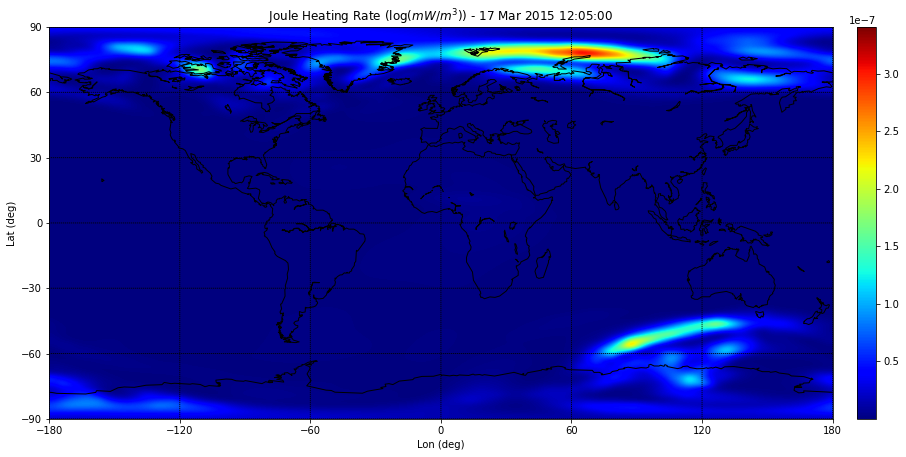

Plotting Polar Plot (North)


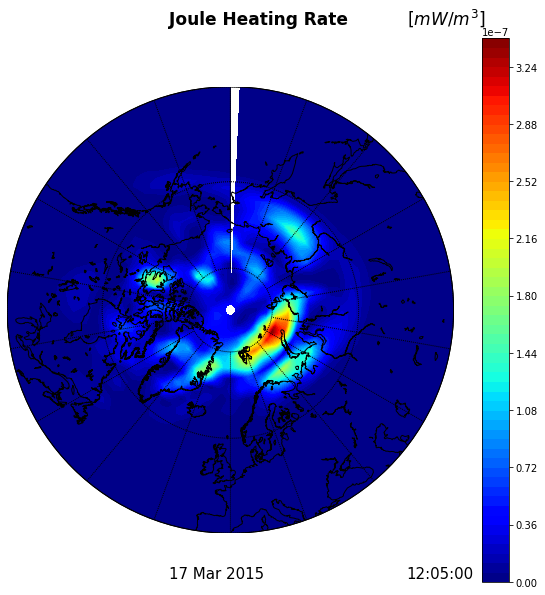

Plotting Ortho Plot


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


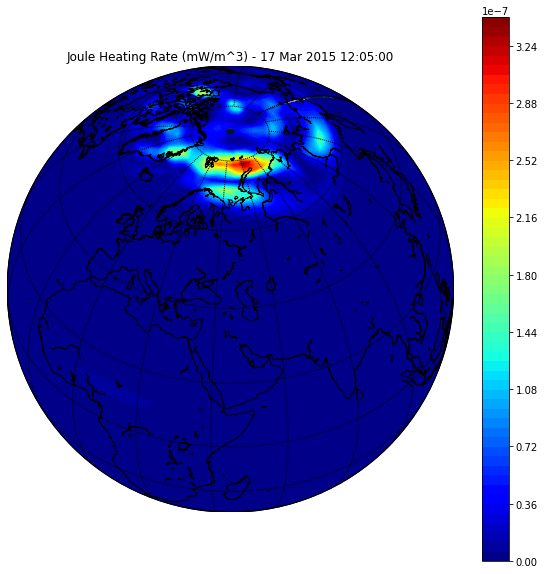

Plotting Quiver Plot


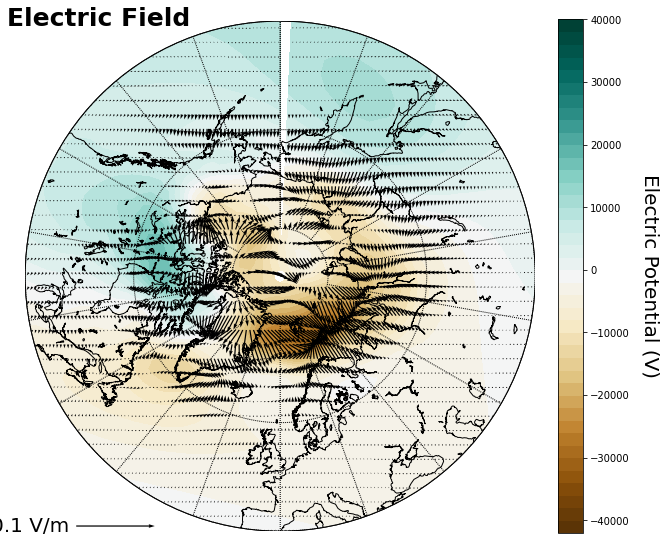

In [7]:
warnings.simplefilter('ignore')

#window creation            
style = {'description_width': '150px'}
layout1stcolumn = {'width': '300px'}
layout2ndcolumn= {'width': '250px'}
layout3rdcolumn= {'width': '100px'}
button_layout={'width': '150px'}
style1 = {'description_width':'150px'}
layout1 = {'width':'850px'}
style2 = {'description_width':'95px'}
layout2 = {'width':'160px'}
layout3 = {'width':'350px'}
style3 = {'description_width':'60px'}
layout4 = {'width':'215px'}

tiegcm_file=widgets.Dropdown(options=sorted(glob.glob(datapath +"*.nc")), description='TIE-GCM files: ', style=style1, layout=layout1)


orbit_file=widgets.Dropdown(options=sorted(glob.glob(datapath  +"DAED_ORB_Evt0_LLA*.csv")), description='Orbit files: ', style=style1, layout=layout1)

lat_value=widgets.Dropdown(
                        options=[('-88.75', 0), ('-86.25', 1), ('-83.75', 2),('-81.25', 3), ('-78.75', 4),('-76.25', 5), ('-73.75', 6),('-71.25', 7),
                        ('-68.75', 8), ('-66.25', 9), ('-63.75', 10),('-61.25', 11), ('-58.75', 12),('-56.25', 13), ('-53.75', 14),('-51.25', 15),
                        ('-48.75', 16), ('-46.25', 17), ('-43.75', 18),('-41.25', 19), ('-38.75', 20),('-36.25', 21), ('-33.75', 22),('-31.25', 23),
                        ('-28.75', 24), ('-26.25', 25), ('-23.75', 26),('-21.25', 27), ('-18.75', 28),('-16.25', 29), ('-13.75', 30),('-11.25', 31),
                        ('-8.75', 32), ('-6.25', 33), ('-3.75', 34),('-1.25', 35), ('1.25', 36),('3.75', 37), ('6.25', 38),('8.75', 39),
                        ('11.25', 40), ('13.75', 41), ('16.25', 42),('18.75', 43), ('21.25', 44),('23.75', 45), ('26.25', 46),('28.75', 47),
                        ('31.25', 48),('33.75', 49), ('36.25', 50),('38.75', 51), ('41.25', 52),('43.75', 53),
                        ('46.25', 54),('48.75', 55), ('51.25', 56),('53.75', 57), ('56.25', 58),('58.75', 59),
                        ('61.25', 60),('63.75', 61), ('66.25', 62),('68.75', 63), ('71.25', 64),('73.75', 65),
                        ('76.25', 66),('78.75', 67), ('81.25', 68),('83.75', 69), ('84.25', 70),('87.75', 71)],
                        value=61,
                        description='Latitude (deg):',
                        layout=layout1stcolumn, 
                        style=style
                        )
lon_value=widgets.Dropdown(
                        options=[('-180.0', 0), 
                                 ('-177.5', 1), ('-175.0', 2),('-172.5', 3), ('-170.0', 4),('-167.5', 5), ('-165.0', 6),('-162.5', 7), ('-160.0', 8), 
                                 ('-157.5', 9), ('-155.0', 10),('-152.5', 11), ('-150.0', 12),('-147.5', 13),('-145.0', 14),('-142.5', 15),('-140.0', 16), 
                                 ('-137.5', 17), ('-135.0', 18),('-132.5', 19), ('-130.0', 20),('-127.5', 21), ('-125.0', 22),('-122.5', 23),('-120.0', 24), 
                                 ('-117.5', 25), ('-115.0', 26),('-112.5', 27), ('-110.0', 28),('-107.5', 29), ('-105.0', 30),('-102.5', 31),('-100.0', 32), 
                                 ('-97.5', 33), ('-95.0', 34),('-92.5', 35),('-90.0', 36),('-87.5', 37),('-85.0', 38),('-82.5', 39),('-80.0', 40), 
                                 ('-77.5', 41), ('-75.0', 42),('-72.5', 43),('-70.0', 44),('-67.5', 45),('-65.0', 46),('-62.5', 47),('-60.0', 48),
                                 ('-57.5', 49), ('-55.0', 50),('-52.5', 51),('-50.0', 52),('-47.5', 53),('-45.0', 54),('-42.5', 55),('-40.0', 56),
                                 ('-37.5', 57), ('-35.0', 58),('-32.5', 59),('-30.0', 60),('-27.5', 61),('-25.0', 62),('-22.5', 63),('-20.0', 64),
                                 ('-17.5', 65), ('-15.0', 66),('-12.5', 67),('-10.0', 68),('-7.5', 69), ('-5.0', 70),('-2.5', 71),('0.0', 72),
                                 ('2.5', 73), ('5.0', 74),('7.5', 75),('10.0', 76),('12.5', 77), ('15.0', 78),('17.5', 79),('20.0', 80),('22.5', 81),
                                 ('25.0', 82), ('27.5', 83),('30.0', 84),('32.5', 85),('35.0', 86), ('37.5', 87),('40.0', 88),('42.5', 89),('45.0', 90),
                                 ('47.5', 91),('50.0', 92),('52.5', 93),('55.0', 94), ('57.5', 95),('60.0', 96),('62.5', 97),('65.0', 98),
                                 ('67.5', 99),('70.0', 100),('72.5', 101),('75.0', 102), ('77.5', 103),('80.0', 104),('82.5', 105),('85.0', 106),
                                 ('87.5', 107),('90.0', 108),('92.5', 109),('95.0', 110), ('97.5', 111),('100.0', 112),('102.5', 113),('105.0', 114),
                                 ('107.5', 115),('110.0', 116),('112.5', 117),('115.0', 118), ('117.5', 119),('120.0', 120),
                                 ('122.5', 121),('125.0', 122),('127.5', 123),('130.0', 124), ('132.5', 125),('135.0', 126),
                                 ('137.5', 127),('140.0', 128),('142.5', 129),('145.0', 130), ('147.5', 131),('150.0', 132),
                                 ('152.5', 133),('155.0', 134),('157.5', 135),('160.0', 136), ('162.5', 137),('165.0', 138),
                                 ('167.5', 139),('170.0', 140),('172.5', 141),('175.0', 142), ('177.5', 143),
                                ],
                        value=25,
                        description='Longitude (deg):',
                        layout=layout1stcolumn, 
                        style=style
                        )




plot_param=widgets.Dropdown(
            options=['Joule Heating','Frictional Heating','Ohmic Heating',
                     'Convenction Heating', 'Ion Heating Rate',
                     'Wind Heating', 'Mechanical Power', 'Pedersen', 'Hall', 'Parallel','O','O2','N2', 'O+',
                     'O2+','NO+','Ne', 
                     'Ti','Tn','Te','νin','νen', 'σ','Potential'],
            value='Joule Heating',
            description='Parameter to Plot:',
            disabled=False,
            style=style, 
            layout=layout1stcolumn
            )
quiver_back_param=widgets.Dropdown(
            options=['Potential', 'Joule Heating','Frictional Heating','Ohmic Heating','Convenction Heating','Ion Heating Rate',
                     'Wind Heating', 'Mechanical Power','Current','Pedersen','Hall','Parallel','Ion Drift'],
            value='Potential',
            description='Background:',
            disabled=False,
            style=style, 
            layout=layout1stcolumn
            )

quiver_vec_param=widgets.Dropdown(
            options=['Electric Field', 'Magnetic Field', 'Pedersen Current', 'Hall Current', 'Perpendicular Current', 'Ion Velocity',
                    'Neutral Winds','JxB'],
            value='Electric Field',
            description='Vector Field:',
            disabled=False,
            style=style, 
            layout=layout1stcolumn
            )
quiver_plot_param=widgets.Dropdown(
            options=['Vector','Streamplot'],
            value='Vector',
            description='Projection:',
            disabled=False,
            style=style, 
            layout=layout1stcolumn
            )

timer_value= widgets.Dropdown( value=0, options=range(0,24),  description='TimeStep:', style=style, layout=layout1stcolumn)
pressure_level= widgets.Dropdown( value=0, options=range(0,57),  description='Pressure Level:', style=style, layout=layout1stcolumn)
heatings_checkbox   = widgets.Checkbox(value=True,  description="Plot Heating Rates", style=style1, layout=layout1 )
frequencies_checkbox   = widgets.Checkbox(value=False,  description="Plot Frequencies", style=style1, layout=layout1 )
densities_checkbox   = widgets.Checkbox(value=False,  description="Plot Densities", style=style1, layout=layout1 )
temperatures_checkbox   = widgets.Checkbox(value=False,  description="Plot Temperatures", style=style1, layout=layout1 )

conductivities_checkbox   = widgets.Checkbox(value=False,  description="Plot Conductivities", style=style1, layout=layout1 )
currents_checkbox   = widgets.Checkbox(value=False,  description="Plot Currents", style=style1, layout=layout1 )
velocities_checkbox   = widgets.Checkbox(value=False,  description="Plot Velocities", style=style1, layout=layout1 )



Joule_checkbox= widgets.Checkbox(value=True,  description="Map Plot",style=style1, layout=layout1 )
Joule_polar= widgets.Checkbox(value=True,  description="Polar Plot",style=style1, layout=layout1 )
Joule_ortho= widgets.Checkbox(value=True,  description="Orthographic Plot",style=style1, layout=layout3 )
Bounding_lat  = widgets.BoundedIntText(value=40, min=10, max=180, description='Bounding Latitude:', style=style1, layout=layout4)
North_plot= widgets.Checkbox(value=True,  description="Plot North Pole",style=style3, layout=layout3 )
South_plot= widgets.Checkbox(value=False,  description="Plot South Pole",style=style3, layout=layout3 )
center_lat  = widgets.BoundedIntText(value=45, min=-90, max=90, description='Center Latitude:', style=style1, layout=layout4)
center_lon  = widgets.BoundedIntText(value=45, min=-180, max=180, description='Center Longitude:', style=style1, layout=layout4)
quiver_checkbox= widgets.Checkbox(value=True,  description="Quiver Plot",style=style1, layout=layout1 )
orbit_checkbox= widgets.Checkbox(value=True,  description="Add Orbit",style=style1, layout=layout1 )
night_checkbox= widgets.Checkbox(value=True,  description="Add Nightshade",style=style1, layout=layout1)

def Exec_Btn_Clicked( b ):
    print( "Calculation started..." )
    run(tiegcm_file.value,lat_value.value,lon_value.value,timer_value.value)
    if heatings_checkbox.value == True:
        print( "Plotting heating rates..." )
        plots.plot_heatings(timer_value.value,lat_value,lon_value,savefig=True)
    if frequencies_checkbox.value == True:
        print( "Plotting frequencies..." )
        plots.plot_frequencies(timer_value.value,lat_value,lon_value,savefig=True)
    if densities_checkbox.value == True:
        print( "Plotting densities..." )
        plots.plot_densities(timer_value.value,lat_value,lon_value,savefig=True)
    if temperatures_checkbox.value == True:
        print( "Plotting temperatures..." )
        plots.plot_temperatures(timer_value.value,lat_value,lon_value,savefig=True)
    if conductivities_checkbox.value == True:
        print( "Plotting conductivities..." )
        plots.plot_conductivities(timer_value.value,lat_value,lon_value,savefig=True)
    if currents_checkbox.value == True:
        print( "Plotting currents..." )
        plots.plot_currents(timer_value.value,lat_value,lon_value,savefig=True)
    if velocities_checkbox.value == True:
        print( "Plotting velocities..." ) 
        plots.plot_velocities(timer_value.value,lat_value,lon_value,savefig=True) 
 
        
        
def Exec_Map_Clicked( b ):
    print( "Calculation started..." )

    run_map(tiegcm_file.value,timer_value.value,pressure_level.value)
    if Joule_checkbox.value == True:
        print ("Ploting Map...")
        plots.plot_map_2d(plot_param.value,timer_value.value)
    if Joule_polar.value == True:
        if North_plot.value == True:
            print ("Plotting Polar Plot (North)")
            plots.plot_polar_north(plot_param.value, Bounding_lat.value, orbit_file.value,timer_value.value,savefig=True)
        if South_plot.value == True:
            print ("Plotting Polar Plot (South)")
            plots.plot_polar_south(plot_param.value, Bounding_lat.value, orbit_file.value,timer_value.value,savefig=True)
    if Joule_ortho.value == True:
        print ("Plotting Ortho Plot")
        plots.plot_ortho(plot_param.value,center_lat.value,center_lon.value,timer_value.value,savefig=True)
    if quiver_checkbox.value == True:
        print ("Plotting Quiver Plot")
        plots.plot_quiver(quiver_plot_param.value,quiver_back_param.value, quiver_vec_param.value,timer_value.value,savefig=True)
def Exec_LatAlt_clicked (b):
    print( "Calculation started..." )
    lat_alt(tiegcm_file.value,timer_value.value,lon_value.value)
    plots.plot_lat_alt(plot_param.value,timer_value.value,savefig=True)
    
    
    
def createGUI():
    ## the top level visual elements
    MainPanel = widgets.VBox() 
    MainTab = widgets.Tab() 
    VerticalPanel = widgets.VBox()
    MapPanel = widgets.VBox()
    LatAltPanel= widgets.VBox()
    
    MainTab.children = [ VerticalPanel,    MapPanel , LatAltPanel]
    MainTab.set_title(0, 'Vertical Profiles')
    MainTab.set_title(1, 'Maps')
    MainTab.set_title(2, 'Latitude-Altitude')
    MainPanel.children = [MainTab ]   
    

    PlotVerticalPanel = widgets.VBox()
    PlotVerticalPanel.children = [lat_value,lon_value,timer_value,widgets.VBox([heatings_checkbox,frequencies_checkbox,temperatures_checkbox,
                                 densities_checkbox,conductivities_checkbox,currents_checkbox,velocities_checkbox])]

    QuiverPanel = widgets.HBox()
    QuiverPanel.children =[quiver_checkbox,quiver_plot_param,quiver_back_param,quiver_vec_param]
    
    Exec_Btn = widgets.Button (description='Calculate Products',tooltip="Click here to calculate Daedalus products",)
    Exec_Btn.style.button_color = 'MediumTurquoise'
    Exec_Btn.on_click( Exec_Btn_Clicked )
    VerticalPanel.children = [tiegcm_file, PlotVerticalPanel, Exec_Btn ]
    
    PlotMapPanel = widgets.VBox()
    PlotMapPanel.children = [pressure_level,timer_value, plot_param]
    Map_Btn = widgets.Button (description='Calculate Products',tooltip="Click here to calculate Daedalus products",)
    Map_Btn.style.button_color = 'YellowGreen'
    Map_Btn.on_click( Exec_Map_Clicked )
    MapPanel.children = [ tiegcm_file, PlotMapPanel,Joule_checkbox, widgets.HBox([Joule_polar, North_plot, South_plot, Bounding_lat]), widgets.HBox([Joule_ortho,center_lat,center_lon]),QuiverPanel,widgets.HBox([orbit_checkbox,orbit_file]), night_checkbox, Map_Btn ]
    
    LatAlt=widgets.VBox()
    LatAlt.children =[lon_value,timer_value]

    LatAlt_Btn = widgets.Button (description='Calculate Products',tooltip="Click here to calculate Daedalus products",)
    LatAlt_Btn.style.button_color = 'YellowGreen'
    LatAltPanel.children = [tiegcm_file, LatAlt,plot_param, LatAlt_Btn]
    LatAlt_Btn.on_click( Exec_LatAlt_clicked )

    return MainPanel
display( createGUI() )
